# ENCODE Long Read Sequel2 dataset

This tutorial guides through a typical Long Read Transcriptome Sequencing (LRTS) analysis workflow with isotools, 
using ENCODE Isoseq SequelII Data. It demonstrates the analysis of alternative splicing events within and between sample groups. 

## Preparation
Select the "long read RNA-seq" samples in the ENCODE data portal (https://www.encodeproject.org/) and download aligned .bam files. Here I use all Sequel II samples available at the time of writing, but you choose to process a subset.
Download the files with curl and use samtools to index the bam files.
``` sh
xargs -L 1 curl -O -J -L < ENCODE_files.txt
for bam in *bam; 
    do samtools index $bam
done
```
In addition to the bamfiles, a file metadata.tsv should have been downloaded, which we use to read the sample information. Further you need a reference annotation and a genome fastq file. Please see the Alzheimer tutorial how to get these files. 

## Data Import

In [1]:
from  isotools import Transcriptome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)


In [2]:
#I assume the encode data is in an subdirctory "encode"

#first, process the metadata
metadata=pd.read_csv('encode/metadata.tsv', sep='\t')
platform={r['Experiment accession']: r['Platform'] for i,r in metadata[~ metadata.Platform.isnull()].iterrows()}

#Select the samples from the metadata (here all SequelII files), make sure there are only bam files are in the table
samples=metadata[(metadata['Output type']=='alignments') & (metadata['File Status']=='released')].copy()
samples['Platform']=[platform.get(ea,'Pacific Biosciences Sequel II') for ea in samples['Experiment accession']] #This info is missing for some files
samples=samples[['File accession','Output type','Biosample term name','Biosample type','Technical replicate(s)','Platform']].reset_index(drop=True) 
samples=samples[samples.Platform=='Pacific Biosciences Sequel II'].reset_index(drop=True) 

#additional infos about the samples
infos=pd.read_csv('encode/encode_samples.tsv', sep='\t').set_index('sample term')


chrom=[f'chr{i+1}'for i in range(22)]+['chrX','chrY']
#ENCODE uses an interesting reference, including sequences from viruses
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'

#print the sample table
samples

File accession Output type                    Biosample term name  \
0     ENCFF745DHX  alignments                                  Panc1   
1     ENCFF400LRT  alignments                                 HCT116   
2     ENCFF545PJV  alignments                                 IMR-90   
3     ENCFF814ABW  alignments                                  HepG2   
4     ENCFF219UJG  alignments                                GM12878   
5     ENCFF044LIA  alignments                                   PC-3   
6     ENCFF322UJU  alignments                                   K562   
7     ENCFF118JEI  alignments                                  MCF-7   
8     ENCFF661OEY  alignments                                   K562   
9     ENCFF645UVN  alignments                                   K562   
10    ENCFF745HHL  alignments                                  aorta   
11    ENCFF509GHY  alignments  progenitor cell of endocrine pancreas   
12    ENCFF803KIA  alignments  progenitor cell of endocrine pancreas   
13    ENCFF971JDY  alignments                     mesenteric fat pad   
14    ENCFF292UIE  alignments                                     H9   
15    ENCFF738RAA  alignments                                     H9   
16    ENCFF911RNV  alignments                   right cardiac atrium   
17    ENCFF472TSL  alignments                    posterior vena cava   
18    ENCFF319JFG  alignments                      neural crest cell   
19    ENCFF901XCR  alignments                      neural crest cell   
20    ENCFF810FRP  alignments                                  HL-60   
21    ENCFF600MGT  alignments                                  HL-60   
22    ENCFF936VUF  alignments                        endodermal cell   
23    ENCFF939EUU  alignments                        endodermal cell   
24    ENCFF648NAR  alignments                                GM12878   
25    ENCFF225CCJ  alignments                                GM12878   
26    ENCFF973OML  alignments                 type B pancreatic cell   
27    ENCFF058HQU  alignments                 type B pancreatic cell   
28    ENCFF779VVX  alignments                lower lobe of left lung   
29    ENCFF305AFY  alignments                  heart right ventricle   
30    ENCFF437SYY  alignments                   heart left ventricle   

                   Biosample type Technical replicate(s)  \
0                       cell line                    1_1   
1                       cell line                    1_1   
2                       cell line                    1_1   
3                       cell line                    1_1   
4                       cell line                    1_1   
5                       cell line                    1_1   
6                       cell line                    1_1   
7                       cell line                    1_1   
8                       cell line                    1_1   
9                       cell line                    2_1   
10                         tissue                    1_1   
11  in vitro differentiated cells                    2_1   
12  in vitro differentiated cells                    1_1   
13                         tissue                    1_1   
14                      cell line                    1_1   
15                      cell line                    2_1   
16                         tissue                    1_1   
17                         tissue                    1_1   
18  in vitro differentiated cells                    1_1   
19  in vitro differentiated cells                    2_1   
20                      cell line                    1_1   
21                      cell line                    2_1   
22  in vitro differentiated cells                    1_1   
23  in vitro differentiated cells                    2_1   
24                      cell line                    1_1   
25                      cell line                    2_1   
26  in vitro differentiated cells                    2_1   
27  in vitro diffe

In [3]:
cols_of_interest=['cell', 'lineage', 'organ', 'karyotype']
try:    
    isoseq=Transcriptome(f'encode/encode_isotools.pkl')
except FileNotFoundError:
    try:
        isoseq=Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        isoseq=Transcriptome.from_reference(anno+'.gff3.gz')
        isoseq.save_reference(anno+'.isotools.pkl')
    for i,row in samples.iterrows():
        sname=f"{row['Biosample term name']}_{row['Technical replicate(s)']}".replace(' ','_')
        if sname in isoseq.samples:
            sname+='_b'
        cell_infos=dict(infos.loc[row['Biosample term name'], cols_of_interest])
        
        isoseq.add_sample_from_bam(f"encode/{row['File accession']}.bam", 
                                   sample_name=sname , 
                                   group=row['Biosample term name'] ,
                                   sample_type=row['Biosample type'],
                                   platform=row['Platform'], **cell_infos) 
    isoseq.add_biases(genome) #3:41 min
    isoseq.make_index()
    isoseq.save('encode/encode_isotools.pkl')


INFO:loading transcriptome from encode/encode_isotools.pklXXX
INFO:importing reference from pkl file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotools.pkl
INFO:adding sample Panc1_1_1
100%|██████████| 1625176.0/1625176 [06:32<00:00, 4140.97reads/s, chr=ERCC-00171]             
INFO:adding sample HCT116_1_1
100%|██████████| 1422477.0/1422477 [05:24<00:00, 4379.02reads/s, chr=ERCC-00171]             
INFO:adding sample IMR-90_1_1
100%|██████████| 1192434.0/1192434 [04:52<00:00, 4070.03reads/s, chr=ERCC-00171]             
INFO:adding sample HepG2_1_1
100%|██████████| 2516897.0/2516897 [09:39<00:00, 4344.73reads/s, chr=ERCC-00171]              
INFO:adding sample GM12878_1_1
100%|██████████| 1526058.0/1526058 [04:47<00:00, 5312.07reads/s, chr=ERCC-00171]              
INFO:adding sample PC-3_1_1
100%|██████████| 1965521.0/1965521 [07:07<00:00, 4598.16reads/s, chr=ERCC-00171]              
INFO:adding sample K562_1_1
100%|██████████| 1958209.0/1958209 [07:07<00:00, 4583

## Quality control and filtering
First, we will depict some quality metrics and define filtering criteria.

In [4]:
from isotools import DEFAULT_GENE_FILTER, DEFAULT_TRANSCRIPT_FILTER,DEFAULT_REF_TRANSCRIPT_FILTER
#add gencode specific filters
ref_filter=DEFAULT_REF_TRANSCRIPT_FILTER
ref_filter['HIGH_SUPPORT']='transcript_support_level=="1"'
ref_filter['PROTEIN_CODING']='transcript_type=="protein_coding"'

#encode bams do not have chimeric reads 
gene_filter=DEFAULT_GENE_FILTER
del gene_filter['CHIMERIC']
isoseq.add_filter( gene_filter=gene_filter, ref_transcript_filter=ref_filter)


100%|██████████| 529144/529144 [00:59<00:00, 8874.80it/s] 


In [5]:
#compute some summary statistics on technical artifacts. 
# For this analysis samples are grouped by 'Biosample term name'
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( remove=['NOVEL_GENE']), ref_filter=dict(include=['HIGH_SUPPORT'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( remove=['NOVEL_GENE', 'UNSPLICED']), ref_filter=dict(remove=['UNSPLICED'])),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(include=['NOVEL_GENE', 'UNSPLICED'])),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[2][0].add_suffix(' novel unspliced'),tr_stats[1][0].add_suffix(' known multiexon')],axis=1),tr_stats[2][1]))

#statistic on the filter flags
f_stats=isoseq.filter_stats( groups=isoseq.groups(), weight_by_coverage=True,min_coverage=1)
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

INFO:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:NumExpr defaulting to 8 threads.


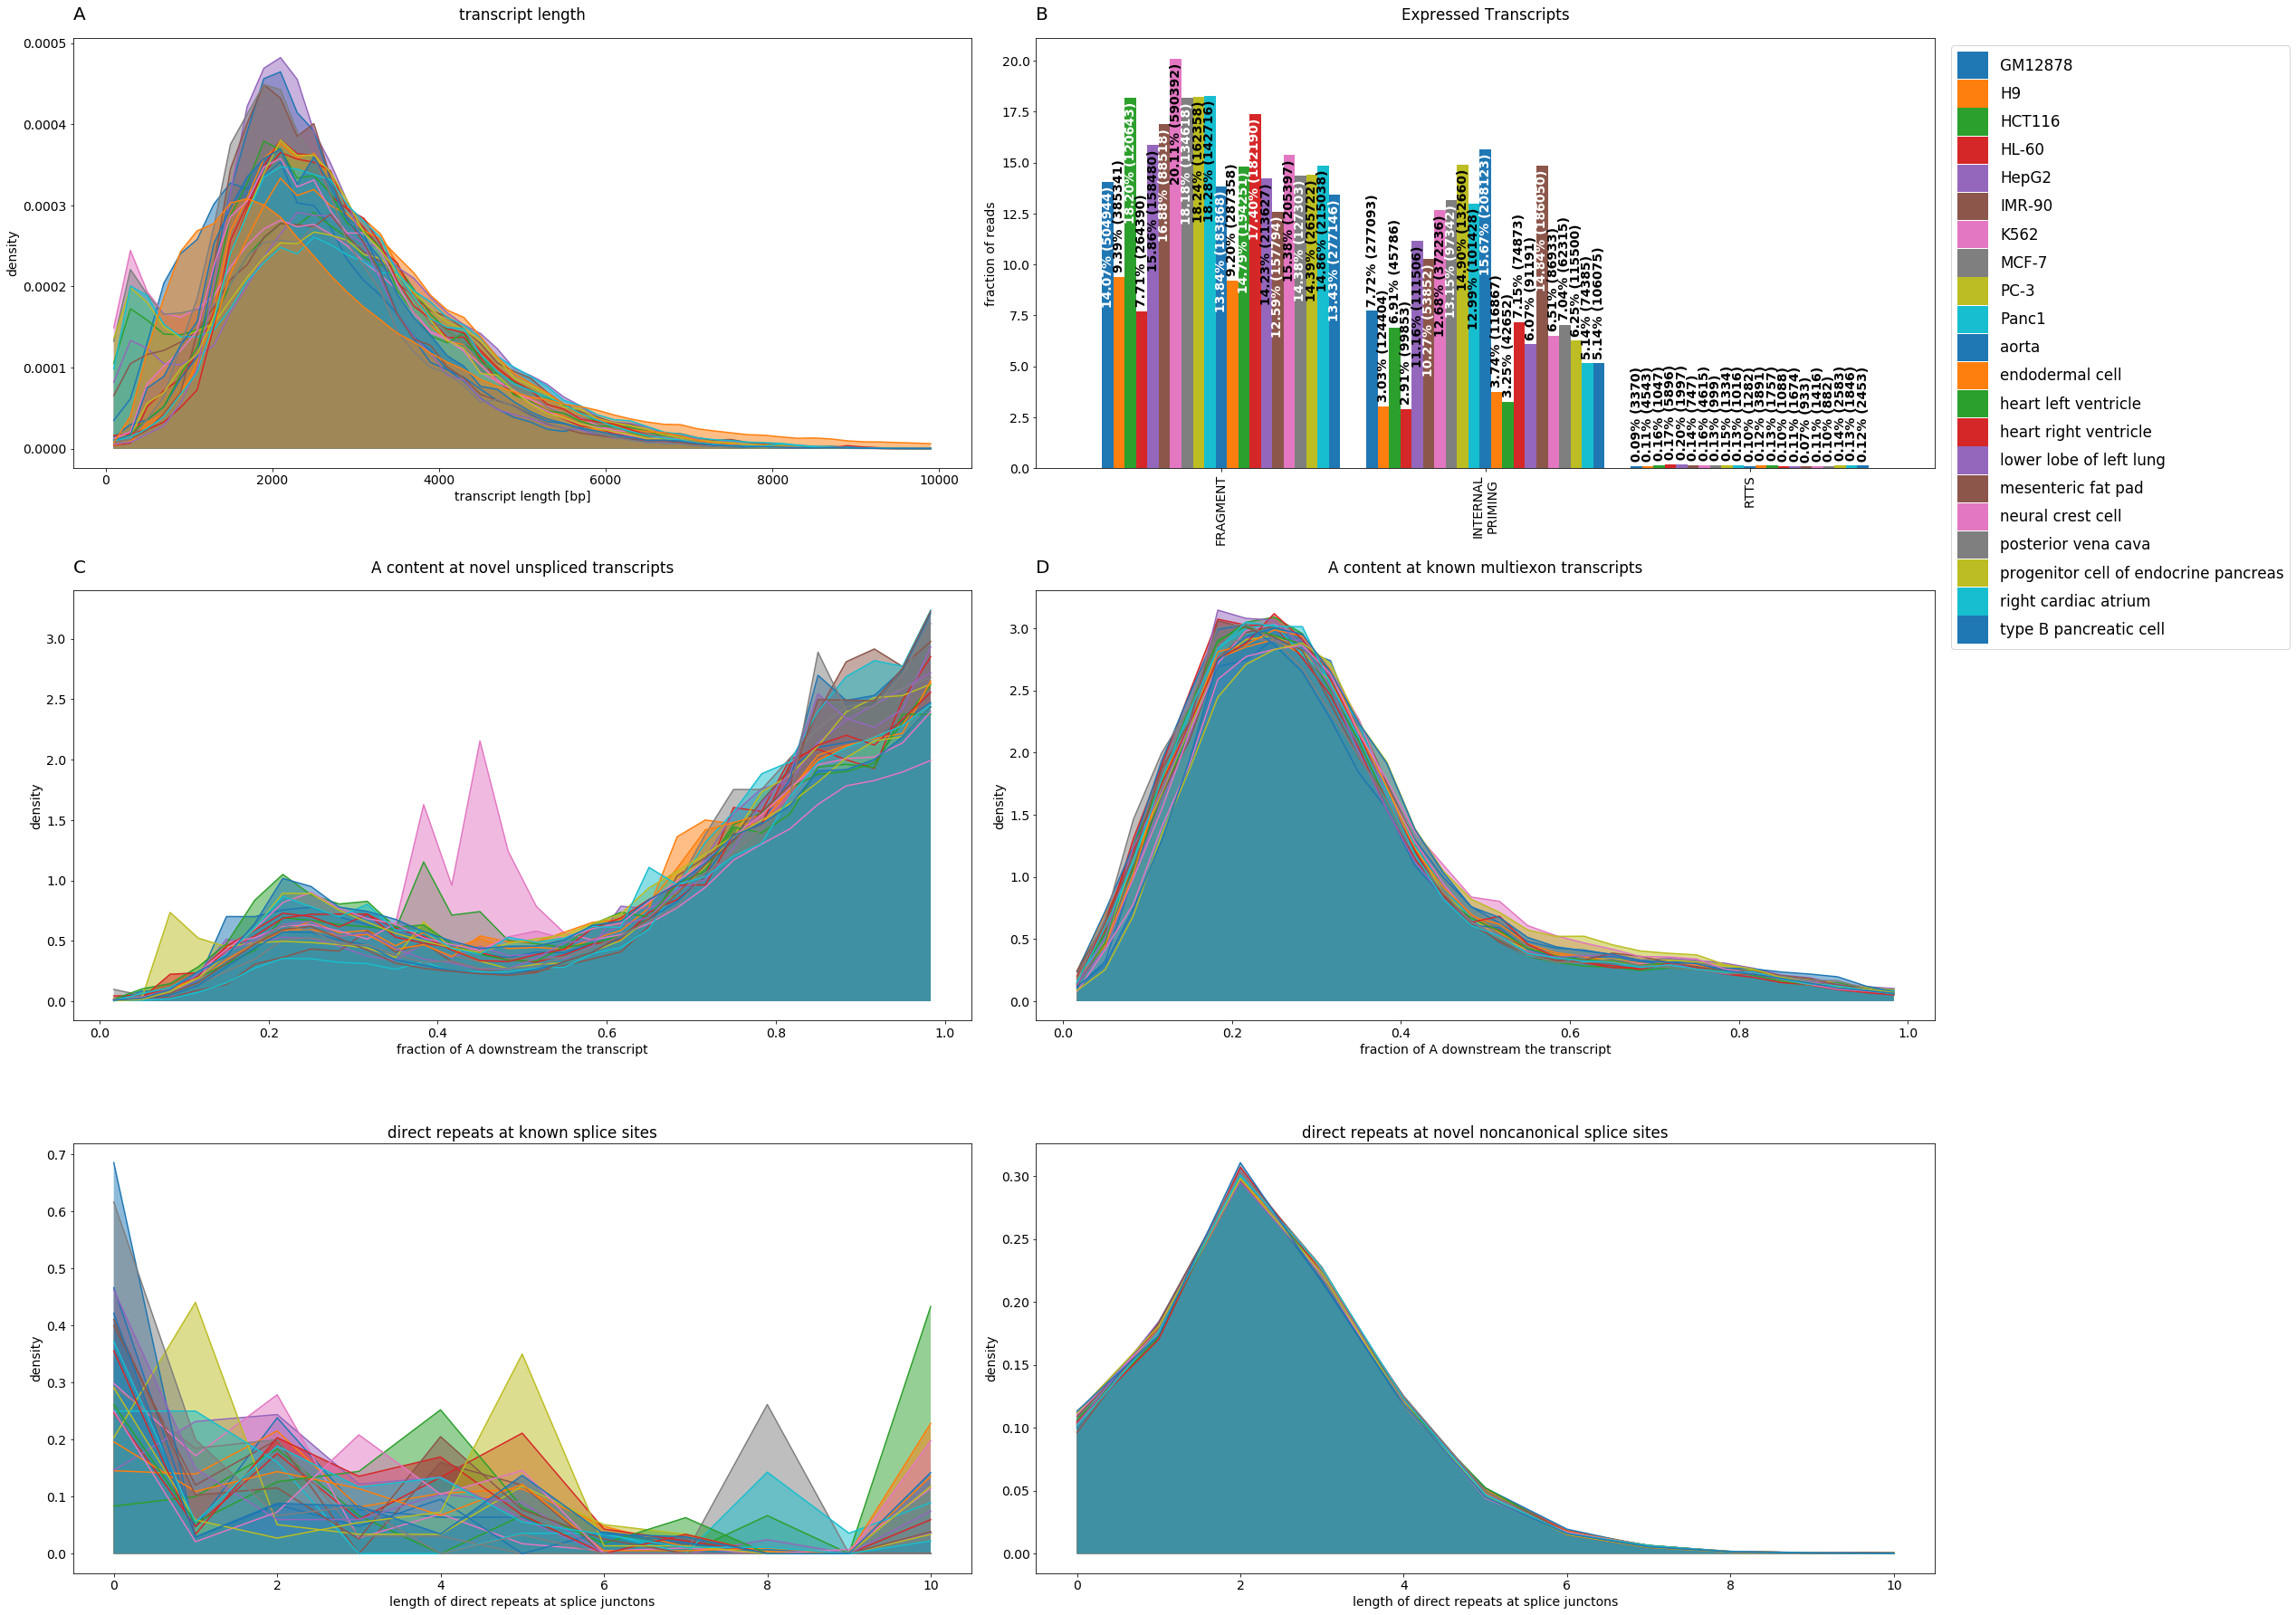

In [6]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(3,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],legend=False,**tr_stats[0][1])  
#D) frequency of artifacts
plot_bar(f_stats[0],ax=axs[0,1],drop_categories=['MULTIEXON','NOVEL\nTRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL\nSPLICING' ],bar_width=.9,legend=False,**f_stats[1])  
#B) internal priming
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'novel' in c]],smooth=3,ax=axs[1,0],legend=False,density=True,fill=True, title= 'A content at novel unspliced transcripts', xlabel='fraction of A downstream the transcript')  
plot_distr(tr_stats[4][0][[c for c in tr_stats[4][0].columns if 'known' in c]],smooth=3,ax=axs[1,1],legend=False,density=True,fill=True, title= 'A content at known multiexon transcripts', xlabel='fraction of A downstream the transcript')  
#C) RTTS
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'novel' in c]],ax=axs[2,0],legend=False,density=True,title='direct repeats at known splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  
plot_distr(tr_stats[3][0][[c for c in tr_stats[3][0].columns if 'known' in c]],ax=axs[2,1],legend=False,density=True,title='direct repeats at novel noncanonical splice sites',ylabel='density',xlabel= 'length of direct repeats at splice junctons')  

for letter,ax in zip('ABCD',axs.flatten()):
    ax.set_title(letter,{'fontsize':20}, loc='left', pad=20)
fig.tight_layout()
axs[0,1].legend(fontsize='large', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.01, 1))


In [7]:
f_stats_sample=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1)


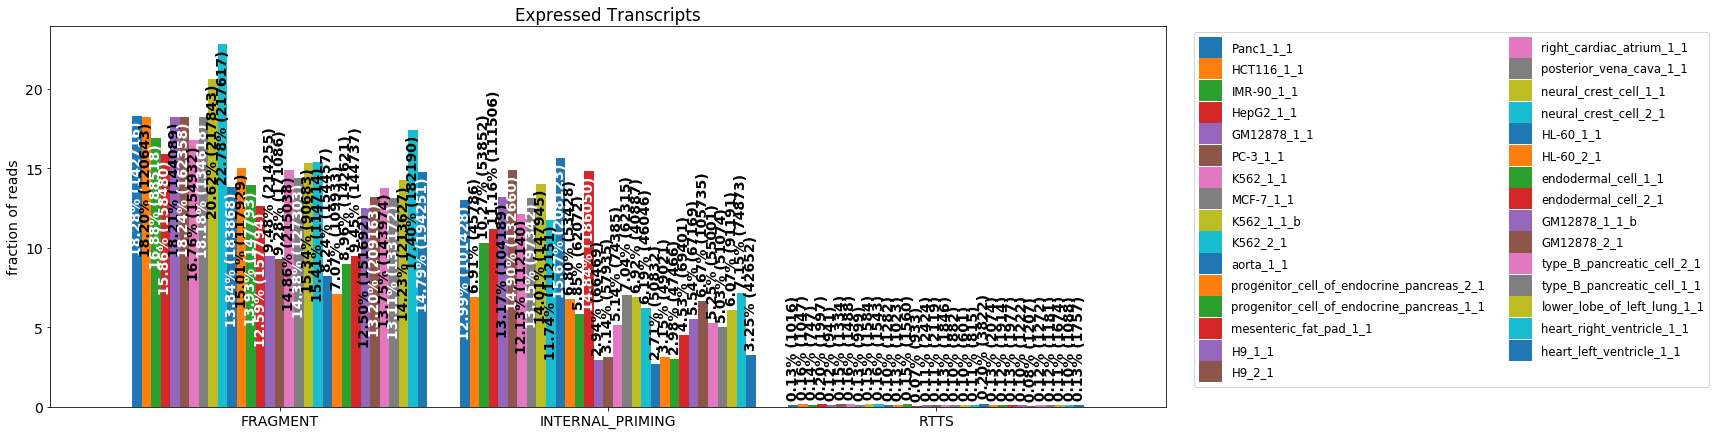

In [8]:
#plot technical artifacts for individual samples
plt.rcParams["figure.figsize"] = (20,7)
plot_bar(f_stats_sample[0],drop_categories=['MULTIEXON','NOVEL_TRANSCRIPT','NOVEL','UNSPLICED','NONCANONICAL_SPLICING' ],legend=False,rot=0, bar_width=.9,**f_stats_sample[1])  
plt.legend(fontsize='small', ncol=2,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1))


## Data Exploration
To explore the relation of the samples with respect to splicing we look at PCA and UMAP embeddings based on alternative splicing events.

In [9]:
#Compute alternative splicing events by finding "bubbles" in the segment graphs
splice_events=isoseq.find_splice_bubbles()

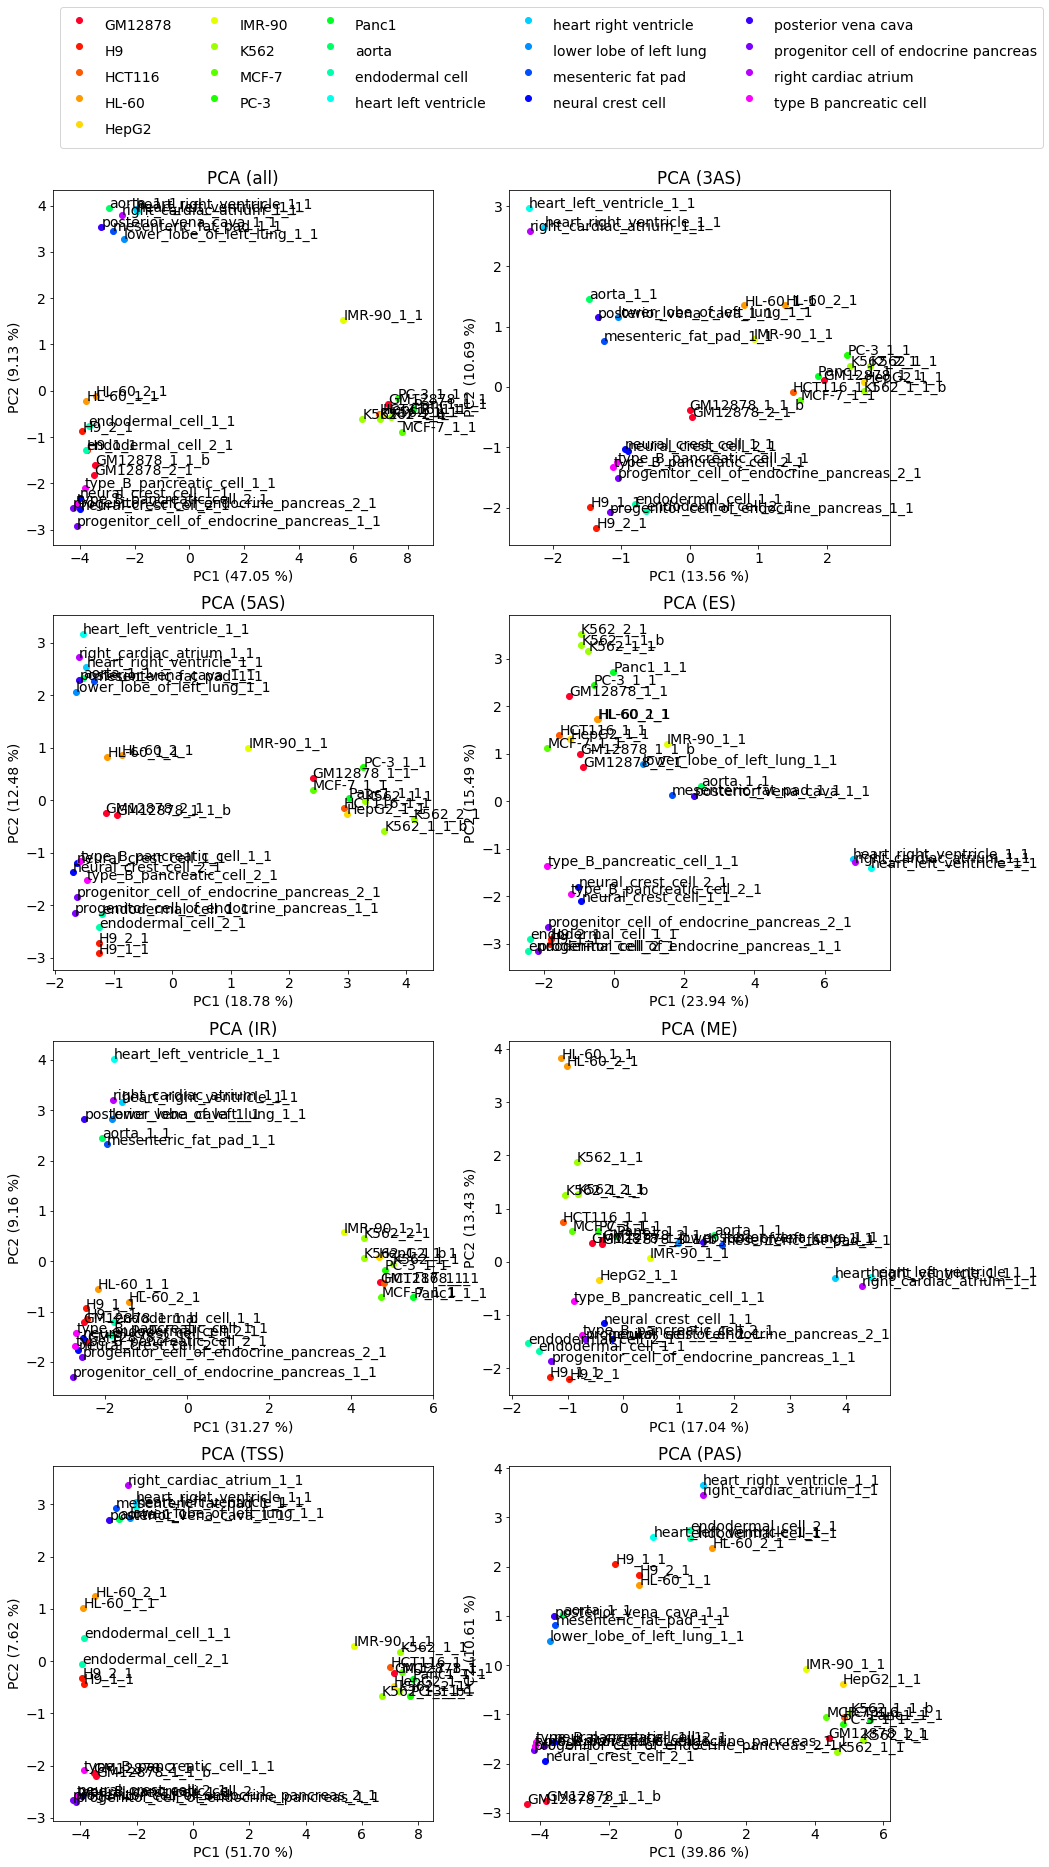

In [10]:
#plot PCA embedding
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (15,30)

pca={}

f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    pca[t]=plot_embedding(splice_events, ax=ax, labels=True, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=5,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')
#plt.tight_layout()


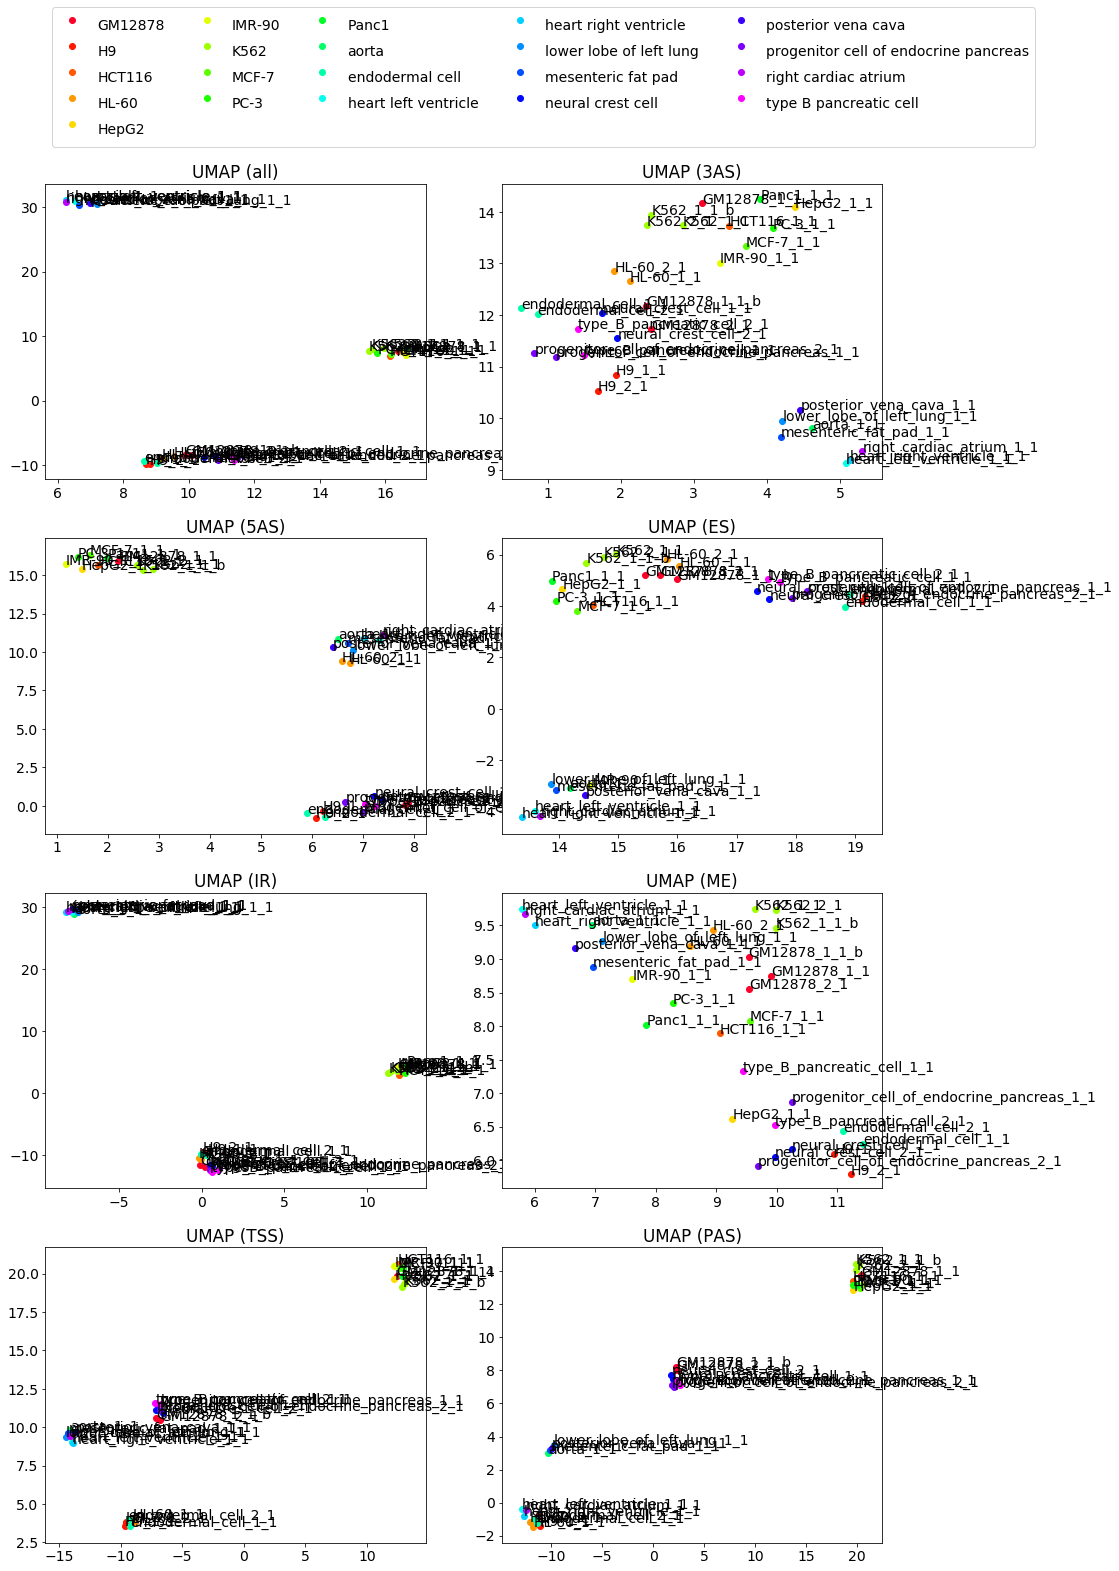

In [11]:
#plot UMAP embedding 
# the clustering of samples very much depends on the n_neighbors parameter
plt.rcParams["figure.figsize"] = (15,25)
umap={}
f,axs=plt.subplots(4,2)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    umap[t]=plot_embedding(splice_events, method='UMAP',n_neighbors=6, ax=ax, labels=True, groups=isoseq.groups(), splice_types=t)
    

axs[0,0].legend(fontsize='medium', ncol=5,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, 1.1), loc='lower left')


INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1, HL-60_1_1, HL-60_2_1
INFO:restricting embedding on samples Panc1_1_1, HCT116_1_1, HepG2_1_1, PC-3_1_1, K562_1_1, MCF-7_1_1, K562_1_1_b, K562_2_1,

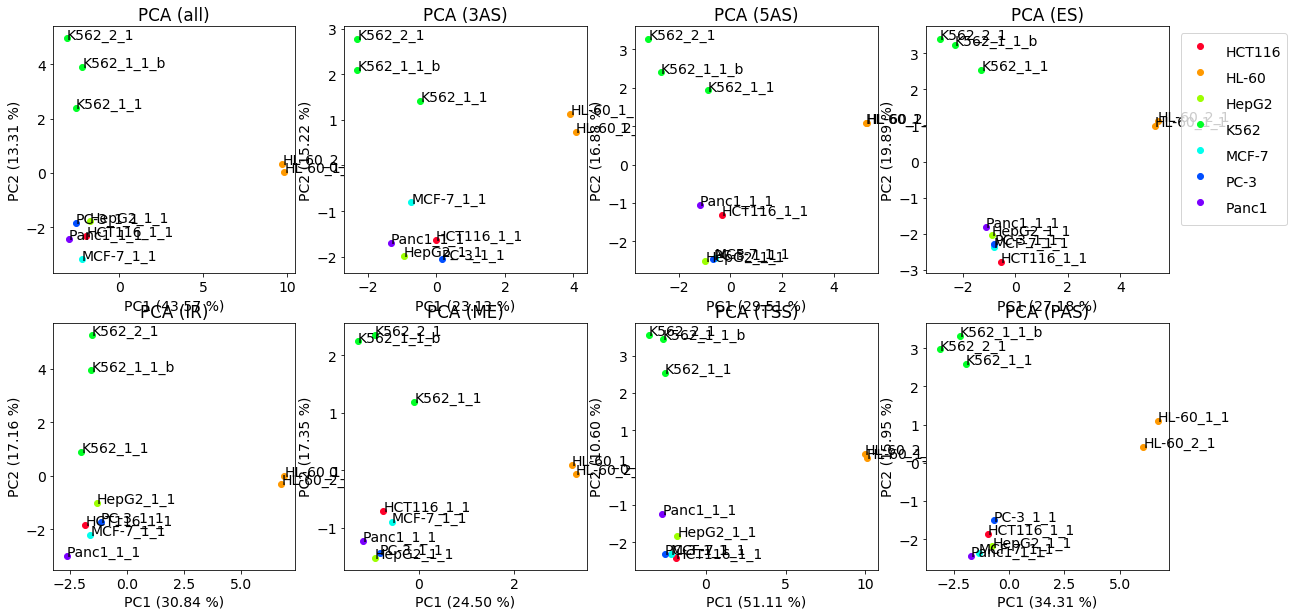

In [12]:
#plot PCA embedding of cancer cell lines only
#This seperates leukemia cell lines from carcinoma cell lines
from isotools.plots import plot_embedding
plt.rcParams["figure.figsize"] = (20,10)
lineage=isoseq.groups('lineage')
sample_type=isoseq.groups('sample_type')
karyotype=isoseq.groups('karyotype')
organ=isoseq.groups('organ')

groups=isoseq.groups()
groups={k:[sa for sa in v if sa in karyotype['cancer']] for k,v in groups.items()}
groups={k:v for k,v in groups.items() if v}
f,axs=plt.subplots(2,4)
for ax,t in zip(axs.flatten(),['all','3AS','5AS','ES','IR','ME', 'TSS', 'PAS']):
    _=plot_embedding(splice_events, ax=ax, labels=True, groups=groups, splice_types=t)
    

axs[0,3].legend(fontsize='medium', ncol=1,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(1.02, 1), loc='upper left')

## Novel Alternative splicing classification

In [13]:

cname=['FSM','ISM','NIC','NNC','novel gene']
cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING'])),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

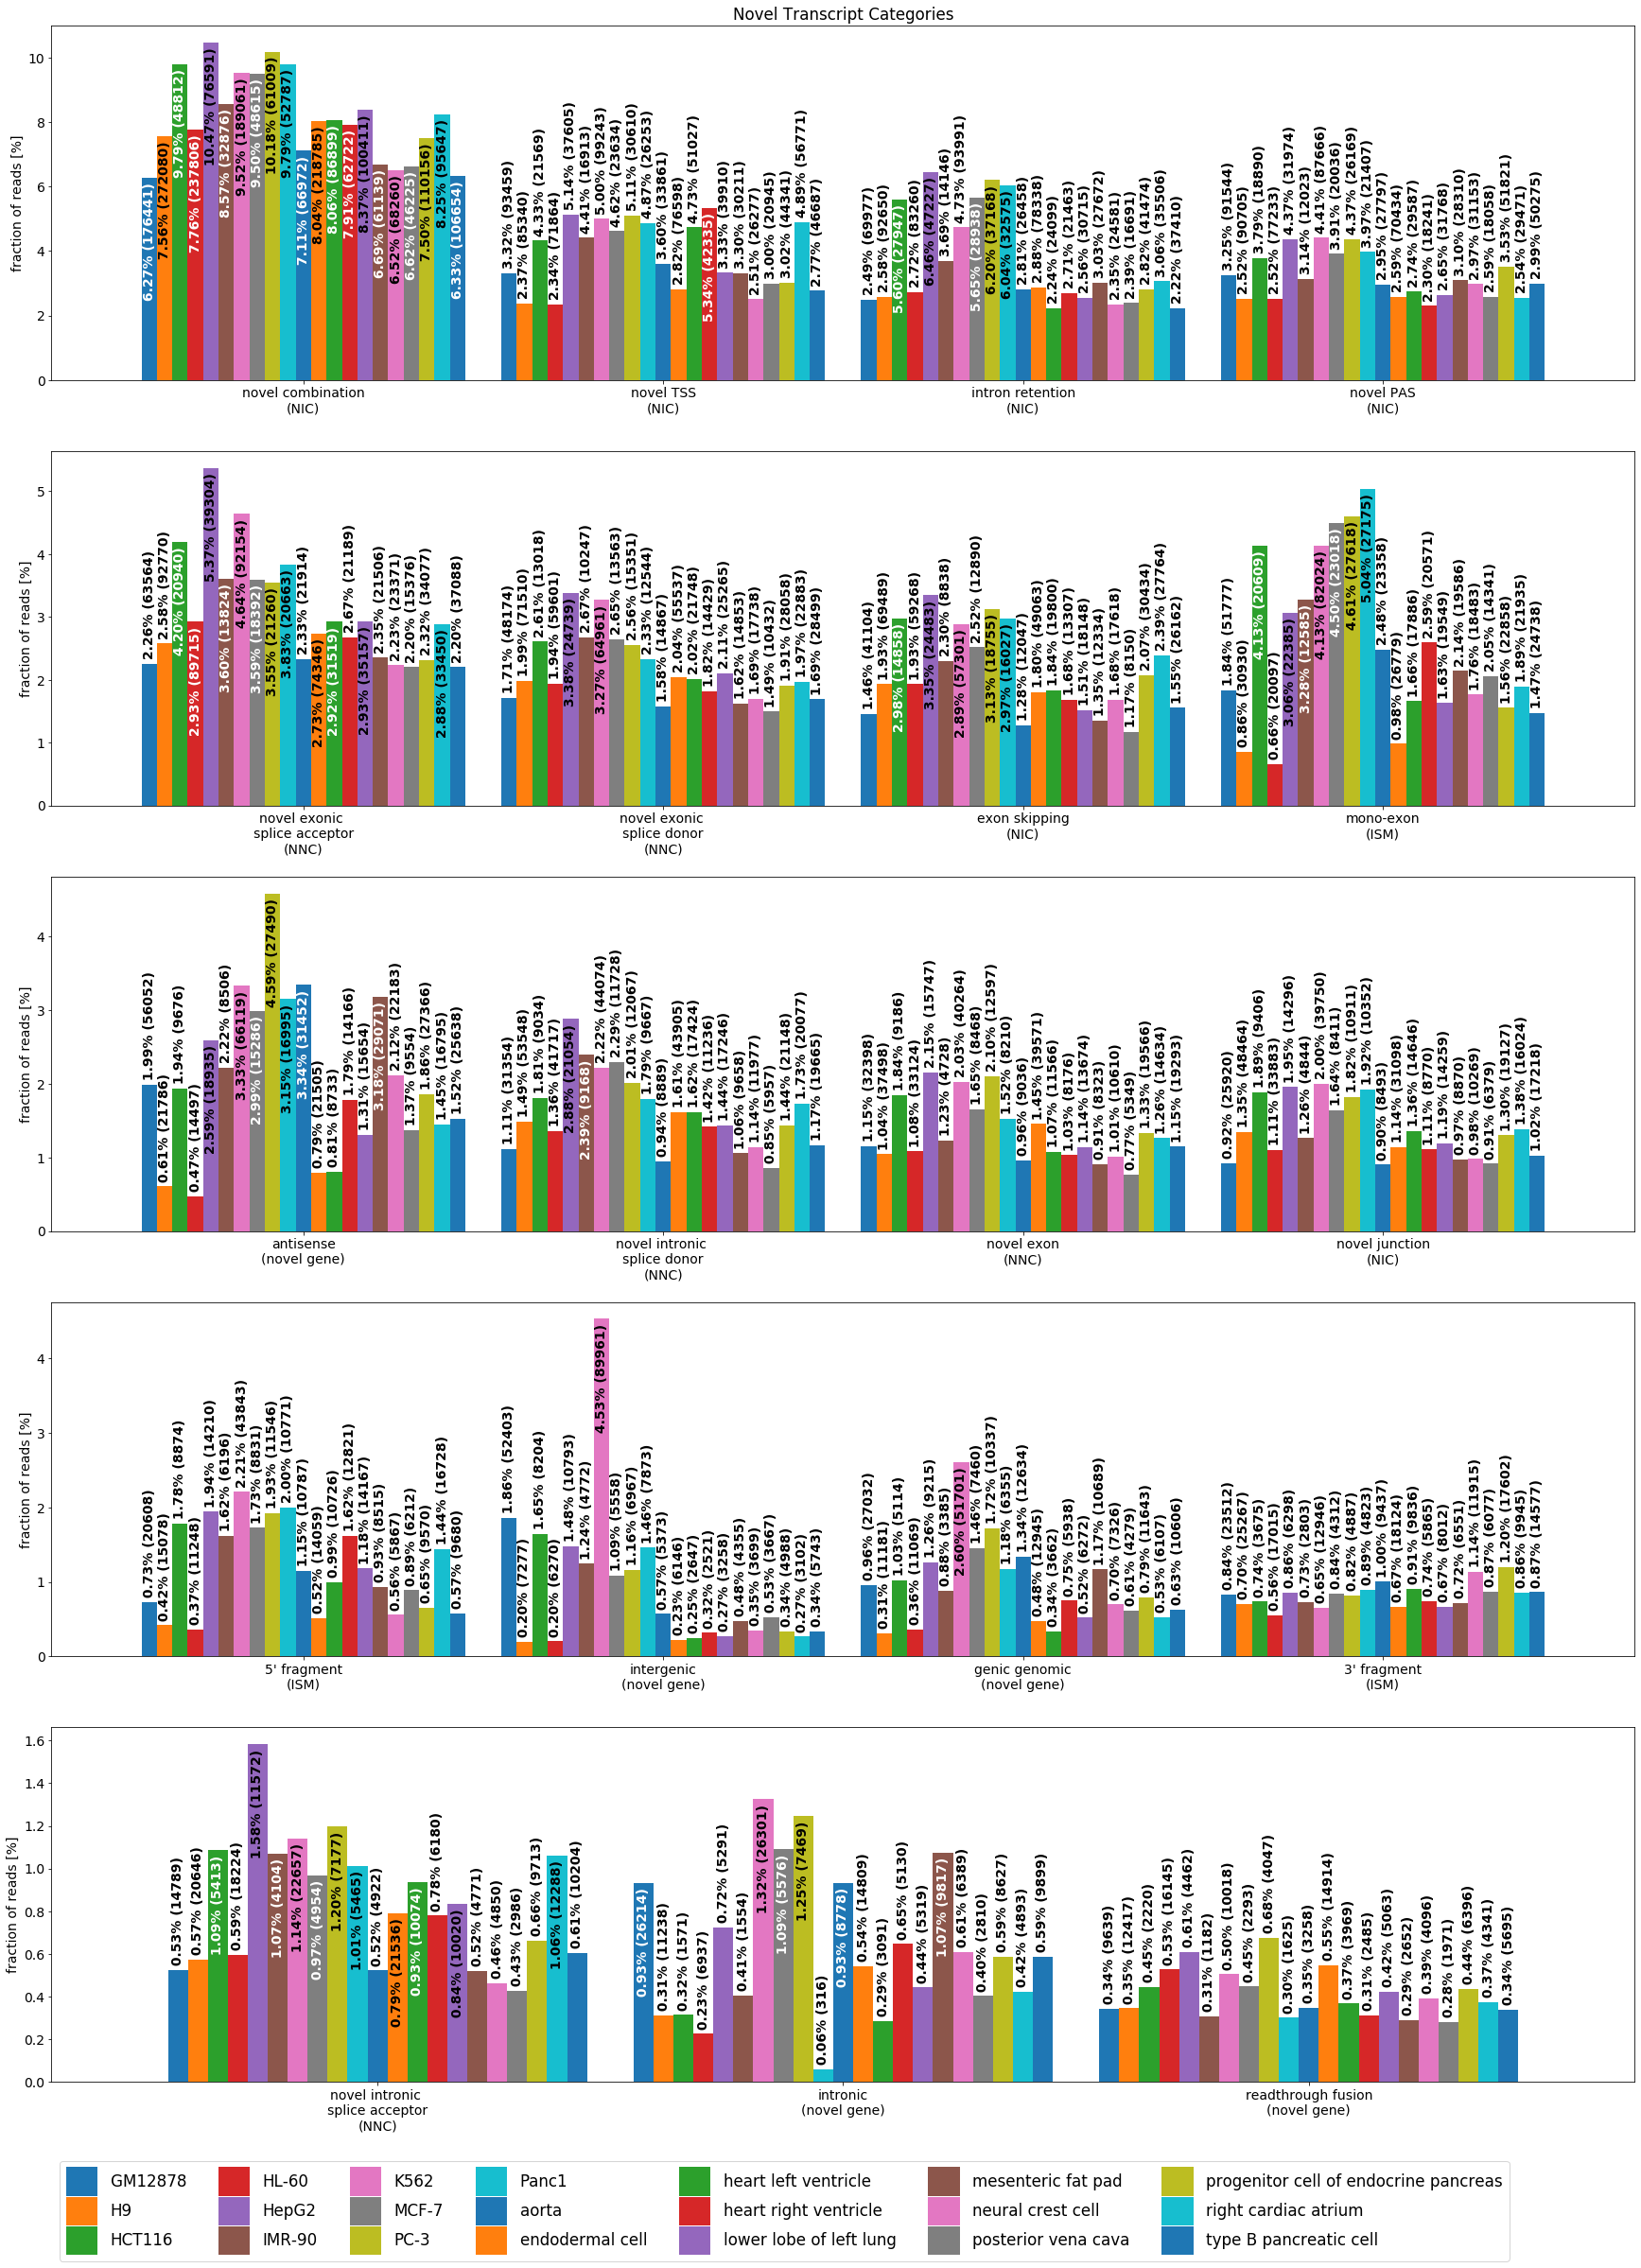

In [14]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (30,40)
fig, axs = plt.subplots( 5)
for i,ax in enumerate(axs):
    cat=altsplice[0][0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice[0][0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice[0][0].index if c not in cat])  
axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

In [15]:
#The same for individual samples
altsplice_sample= isoseq.altsplice_stats( weight_by_coverage=True, min_coverage=1, tr_filter=dict( remove=['RTTS', 'FRAGMENT', 'INTERNAL_PRIMING']))
altsplice_sample[0].index=altsplice_sample[0].index+[f'\n({cname[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice_sample[0].index]


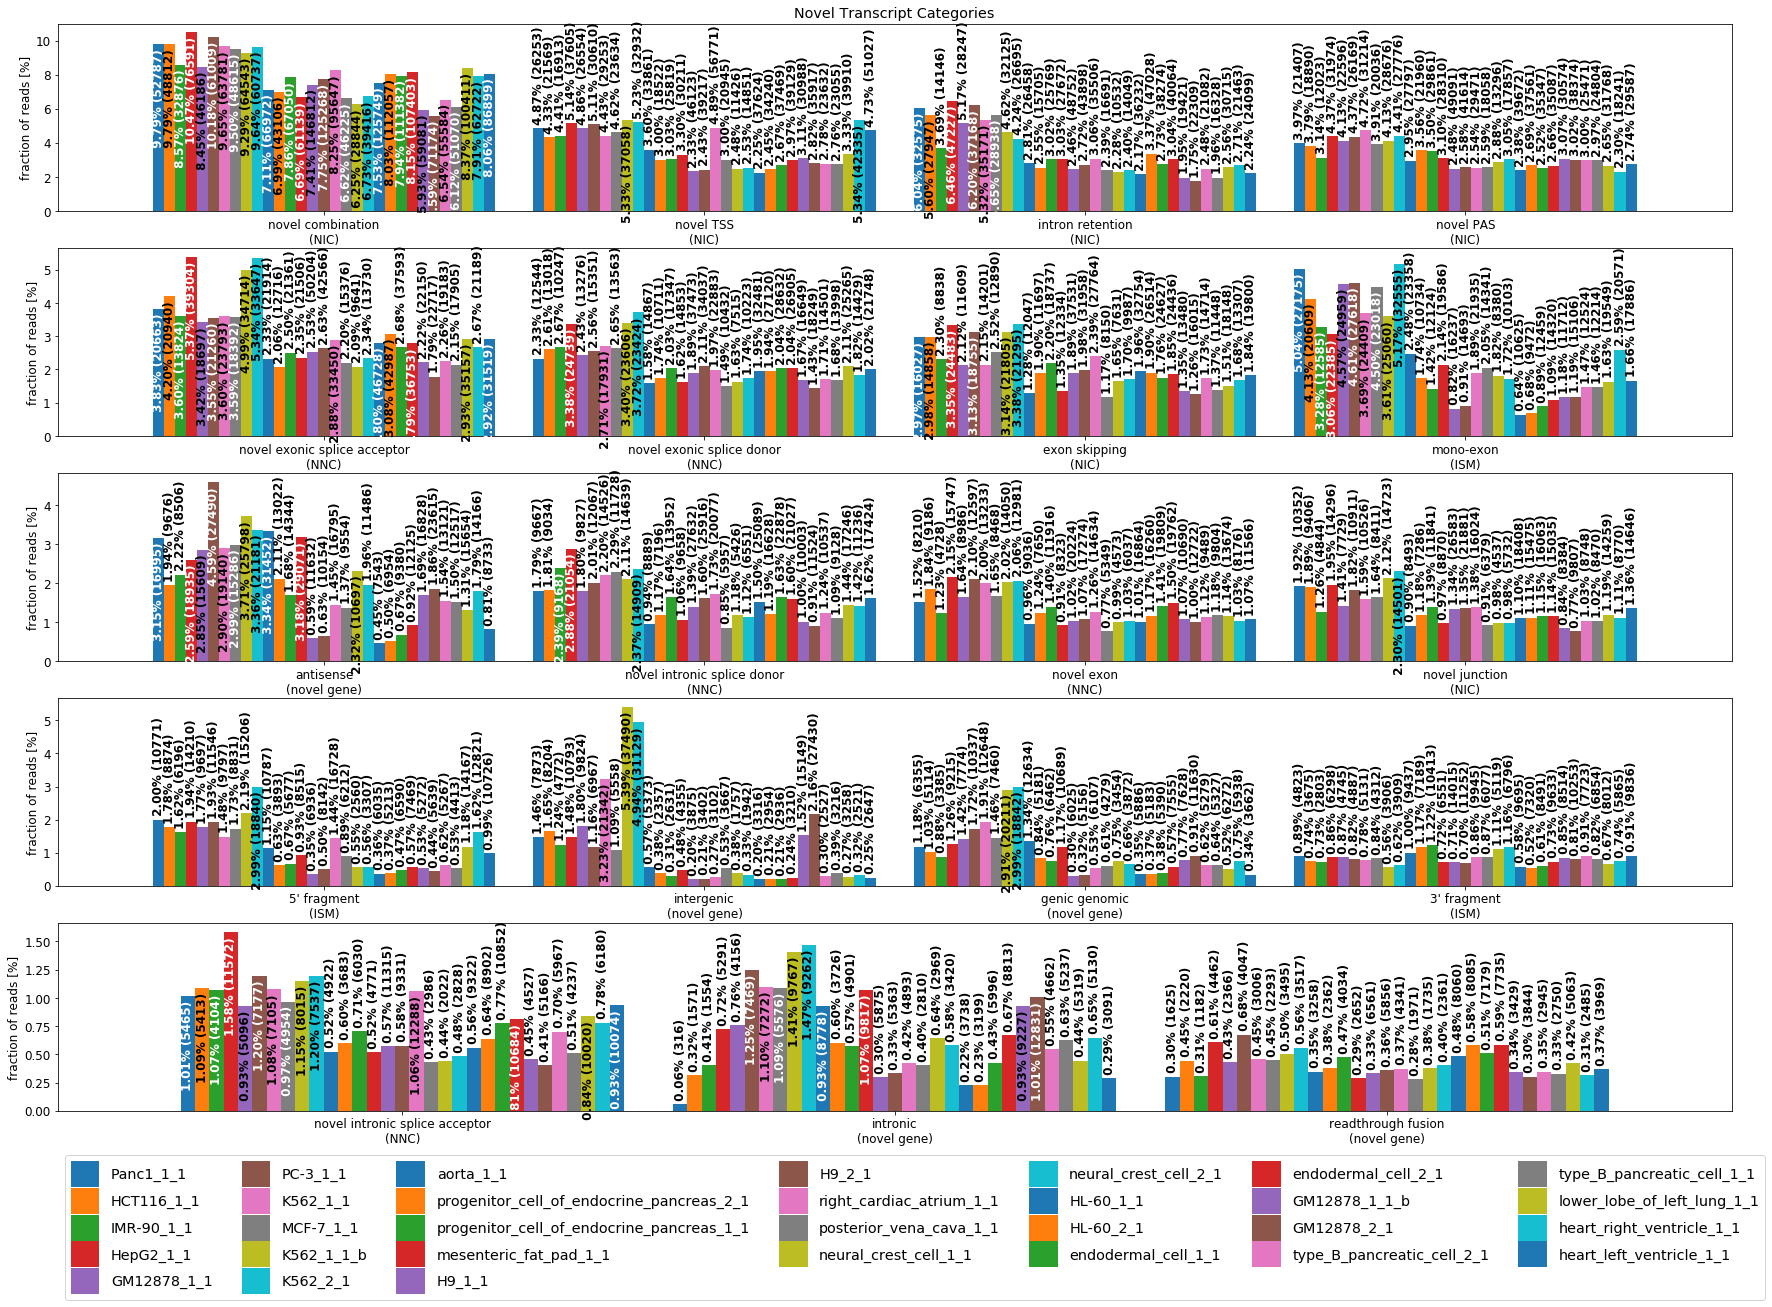

In [16]:
plt.rcParams["figure.figsize"] = (30,20)
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots( 5)


for i,ax in enumerate(axs.flatten()):
    cat=altsplice_sample[0].index[i*4+2:(i+1)*4+2]
    plot_bar(altsplice_sample[0],bar_width=.9,ax=ax,ylabel='fraction of reads [%]', legend=False, rot=0,drop_categories=[c for c in altsplice_sample[0].index if c not in cat])  
handles, labels = axs[0].get_legend_handles_labels()

axs[-1].legend(fontsize='large', ncol=7,handleheight=2.4, labelspacing=0.05, bbox_to_anchor=(0, -.2), loc='upper left')
_=axs[0].set_title('Novel Transcript Categories')

## Differential Splicing

In [17]:
#first we define a function, to depcit the results
def plot_diff_example(row, isoseq, groups):
    #sashimi plot for differential spliced genes
    plt.rcParams["figure.figsize"] = (15,10)
    #select gene object
    g=isoseq[row.gene_id]
    #make the title
    gn=list(groups)
    novel='novel' if row.novel else 'known'
    title=f'{g.name} {row.splice_type} ({novel}) FDR={row.padj:.2e}: {gn[0]}={row[gn[0]+"_PSI"]*100:.1f} vs {gn[1]}={row[gn[1]+"_PSI"]*100:.1f} PSI'
    print(title)
    start=row.start
    end=row.end
    #select the junctions of interest (which will be marked purple in the plot)
    joi=[(start,end)]
    if row.splice_type=='ME' and g.is_annotated:
        try:
            sg=g.ref_segment_graph
            n1=next(n for n in sg if n[1]==start)
            n2=next(n for n in sg if n[0]==end)
            joi={(start,sg[suc].start) for suc in n1.suc.values() if sg[suc].start<end }
            joi.update({(sg[pre].end,end) for pre in n2.pre.values() if sg[pre].end>start })
        except:
            pass
    #draw the plot for the two sample groups from the comparison
    f,axs=g.sashimi_figure(samples=groups , x_range=(start-500, end+500),junctions_of_interest=joi    )
    axs[0].set_title(title)
    fig.tight_layout()

In [18]:
from isotools.plots import plot_diff_results
#We are mostly interested in differential splicing for now.
types_of_interest=['ES','ME','5AS','3AS']
#dict to store the results in
res={}

### Normal endodermal development
First we compare the embryonic stem cell line H9 vs in vitro derived endodermal cells.

In [19]:
diff_cmp='H9/endodermal cell'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 20 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for H9 (2) vs endodermal cell (2) using betabinom_lr test
100%|██████████| 529144/529144 [16:12<00:00, 544.18it/s] 


450 differential splice sites in 317 genes for H9 vs endodermal cell


index    gene             gene_id  chrom strand      start        end  \
0   17246   VDAC1  ENSG00000213585.11   chr5      -  133993015  134004646   
3   10205   CNDP2  ENSG00000133313.15  chr18      +   74496431   74499936   
4   20039   SARAF  ENSG00000133872.14   chr8      -   30070059   30082846   
6    5118   RPLP0  ENSG00000089157.16  chr12      -  120200831  120201082   
8   14051   CXADR  ENSG00000154639.19  chr21      +   17559131   17565427   
9    7541  ZFAND6  ENSG00000086666.19  chr15      +   80059809   80120327   
14   9899    DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
34   9898    DDX5  ENSG00000108654.16  chr17      -   64500326   64502009   
35   8585    IST1  ENSG00000182149.21  chr16      +   71922680   71924768   
39   2618   NODAL  ENSG00000156574.10  chr10      -   70433088   70435285   

   splice_type  novel      padj  ...  total_PSI  total_disp  H9_1_1_H9_in_cov  \
0          3AS  False  0.019927  ...   0.397676    0.097684              2114   
3          3AS  False  0.019927  ...   0.438431    0.045426              1181   
4           ES  False  0.019927  ...   0.525469    0.069543              1074   
6          3AS  False  0.022961  ...   0.406459    0.080456               339   
8           ES  False  0.022961  ...   0.602567    0.085512                84   
9           ES  False  0.022961  ...   0.504624    0.076068               191   
14         5AS   True  0.025960  ...   0.592848    0.095463                57   
34          ES   True  0.042266  ...   0.749084    0.033310               225   
35          ES  False  0.045026  ...   0.573786    0.034286               925   
39          ES   True  0.045395  ...   0.336482    0.066385                73   

    H9_1_1_H9_total_cov  H9_2_1_H9_in_cov  H9_2_1_H9_total_cov  \
0                  2705              1818                 2307   
3                  1777              1002                 1471   
4                  1302               924                 1118   
6                   437               169                  238   
8                   378                90                  322   
9                   235               174                  208   
14                  248                46                  235   
34                  416               253                  442   
35                 1188               789                 1037   
39                 1308                80                 1099   

    endodermal_cell_1_1_endodermal cell_in_cov  \
0                                           26   
3                                          169   
4                                           63   
6                                          161   
8                                          680   
9                                           83   
14                                         216   
34                                         189   
35                                          51   
39                                          93   

    endodermal_cell_1_1_endodermal cell_total_cov  \
0                                             393   
3                                             831   
4                                             264   
6                                            1746   
8                                             734   
9                                             466   
14                                            229   
34                                            202   
35                                            147   
39                                            137   

    endodermal_cell_2_1_endodermal cell_in_cov  \
0                                           14   
3                                          161   
4                                           64   
6                                           77   
8                                          690   
9                                           90   
14                                         191   
34

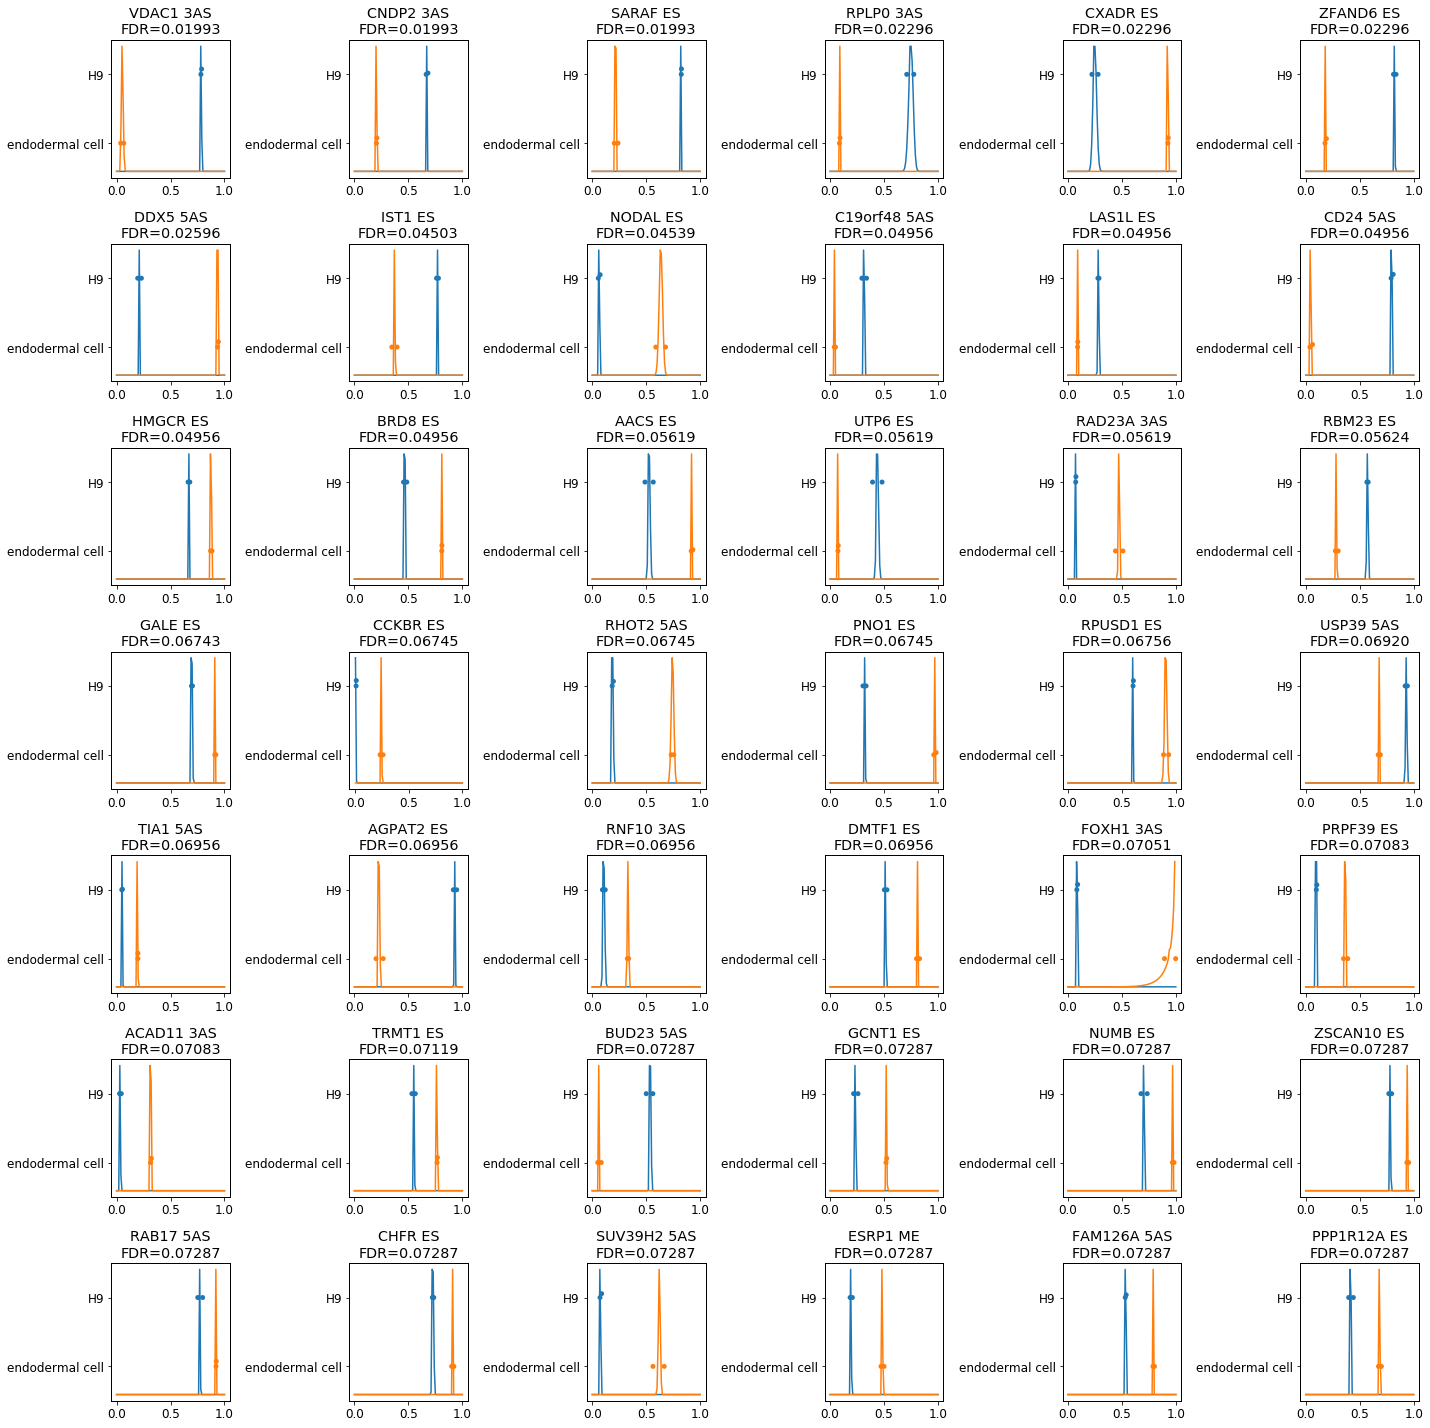

In [24]:
plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

CXADR ES (known) FDR=2.30e-02: H9=24.9 vs endodermal cell=92.8 PSI


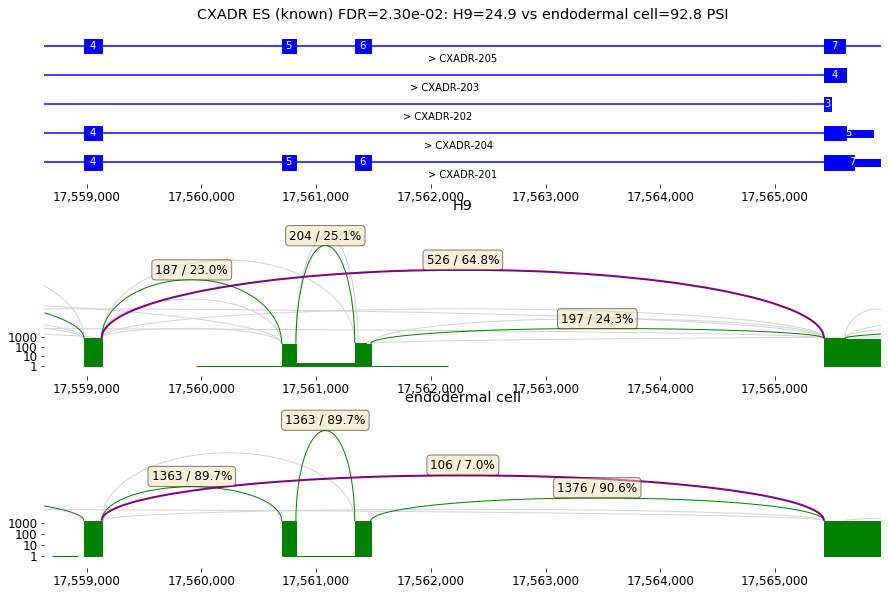

In [25]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[8]
plot_diff_example(row, isoseq, groups)

### Leukemia Cell lines
Both leukemia cell lines HL-60 and K562 (should) have SRSF2 mutations, which should lead to abberant splicing of EZH2. A additional exon leads to inclusion of premature stop codon, resulting in loss of function. We compare them to the B-cell derived cell line GM12878.

see Urbanski et al: Alternative-splicing defects in cancer: splicing regulators and their downstream targets, guiding the way to novel cancer therapeutics
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002934/


In [26]:
diff_cmp='GM12878/HL-60'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#
#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs HL-60 (2) using betabinom_lr test
100%|██████████| 529144/529144 [14:49<00:00, 595.04it/s] 


5454 differential splice sites in 3151 genes for GM12878 vs HL-60


index     gene             gene_id  chrom strand      start        end  \
3   15168  HNRNPDL  ENSG00000152795.17   chr4      -   82424883   82426036   
7    1255   LGALS8  ENSG00000116977.19   chr1      +  236542787  236543559   
8   12542   NELFCD  ENSG00000101158.15  chr20      +   58993675   58994109   
12   6079   HNRNPC  ENSG00000092199.18  chr14      -   21230366   21230996   
16  15778   FIP1L1  ENSG00000145216.16   chr4      +   53399839   53425871   
20   3732  DCUN1D5  ENSG00000137692.12  chr11      -  103066567  103083255   
21  14575  LRRFIP2  ENSG00000093167.18   chr3      -   37083806   37094791   
23   2937  XPNPEP1  ENSG00000108039.18  chr10      -  109907815  109923401   
27  19046    PUF60  ENSG00000179950.14   chr8      -  143818534  143821596   
28   7731    LUC7L  ENSG00000007392.17  chr16      -     208188     220648   

   splice_type  novel      padj  ...  GM12878_1_1_GM12878_in_cov  \
3           ES  False  0.016372  ...                          12   
7           ES  False  0.016372  ...                          13   
8          5AS  False  0.016372  ...                         136   
12         5AS  False  0.016372  ...                         166   
16          ES  False  0.016372  ...                          97   
20          ES  False  0.016372  ...                          86   
21          ES  False  0.016372  ...                          29   
23          ES  False  0.016372  ...                          56   
27          ES  False  0.016372  ...                         252   
28          ES  False  0.016372  ...                           2   

    GM12878_1_1_GM12878_total_cov  GM12878_1_1_b_GM12878_in_cov  \
3                             211                            24   
7                              17                            82   
8                             163                           357   
12                            789                           324   
16                            147                           175   
20                             86                           222   
21                             76                            40   
23                             58                           182   
27                            413                           330   
28                             49                             3   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
3                               898                          37   
7                               111                         107   
8                               398                         361   
12                             1782                         386   
16                              274                         159   
20                              223                         290   
21                              123                          25   
23                              190                         197   
27                              630                          95   
28                               74                           5   

    GM12878_2_1_GM12878_total_cov  HL-60_1_1_HL-60_in_cov  \
3                            1496                   321.0   
7                             150                    14.0   
8                             409                    18.0   
12                           2089                    87.0   
16                            243                   190.0   
20                            293                   117.0   
21                             81                   102.0   
23                            204                   141.0   
27                            154                   170.0   
28                             95                    65.0   

    HL-60_1_1_HL-60_total_cov  HL-60_2_1_HL-60_in_cov  \
3                       486.0                   173.0   
7                       154.0                     9.0   
8                       161.0                    22.0   
12                  

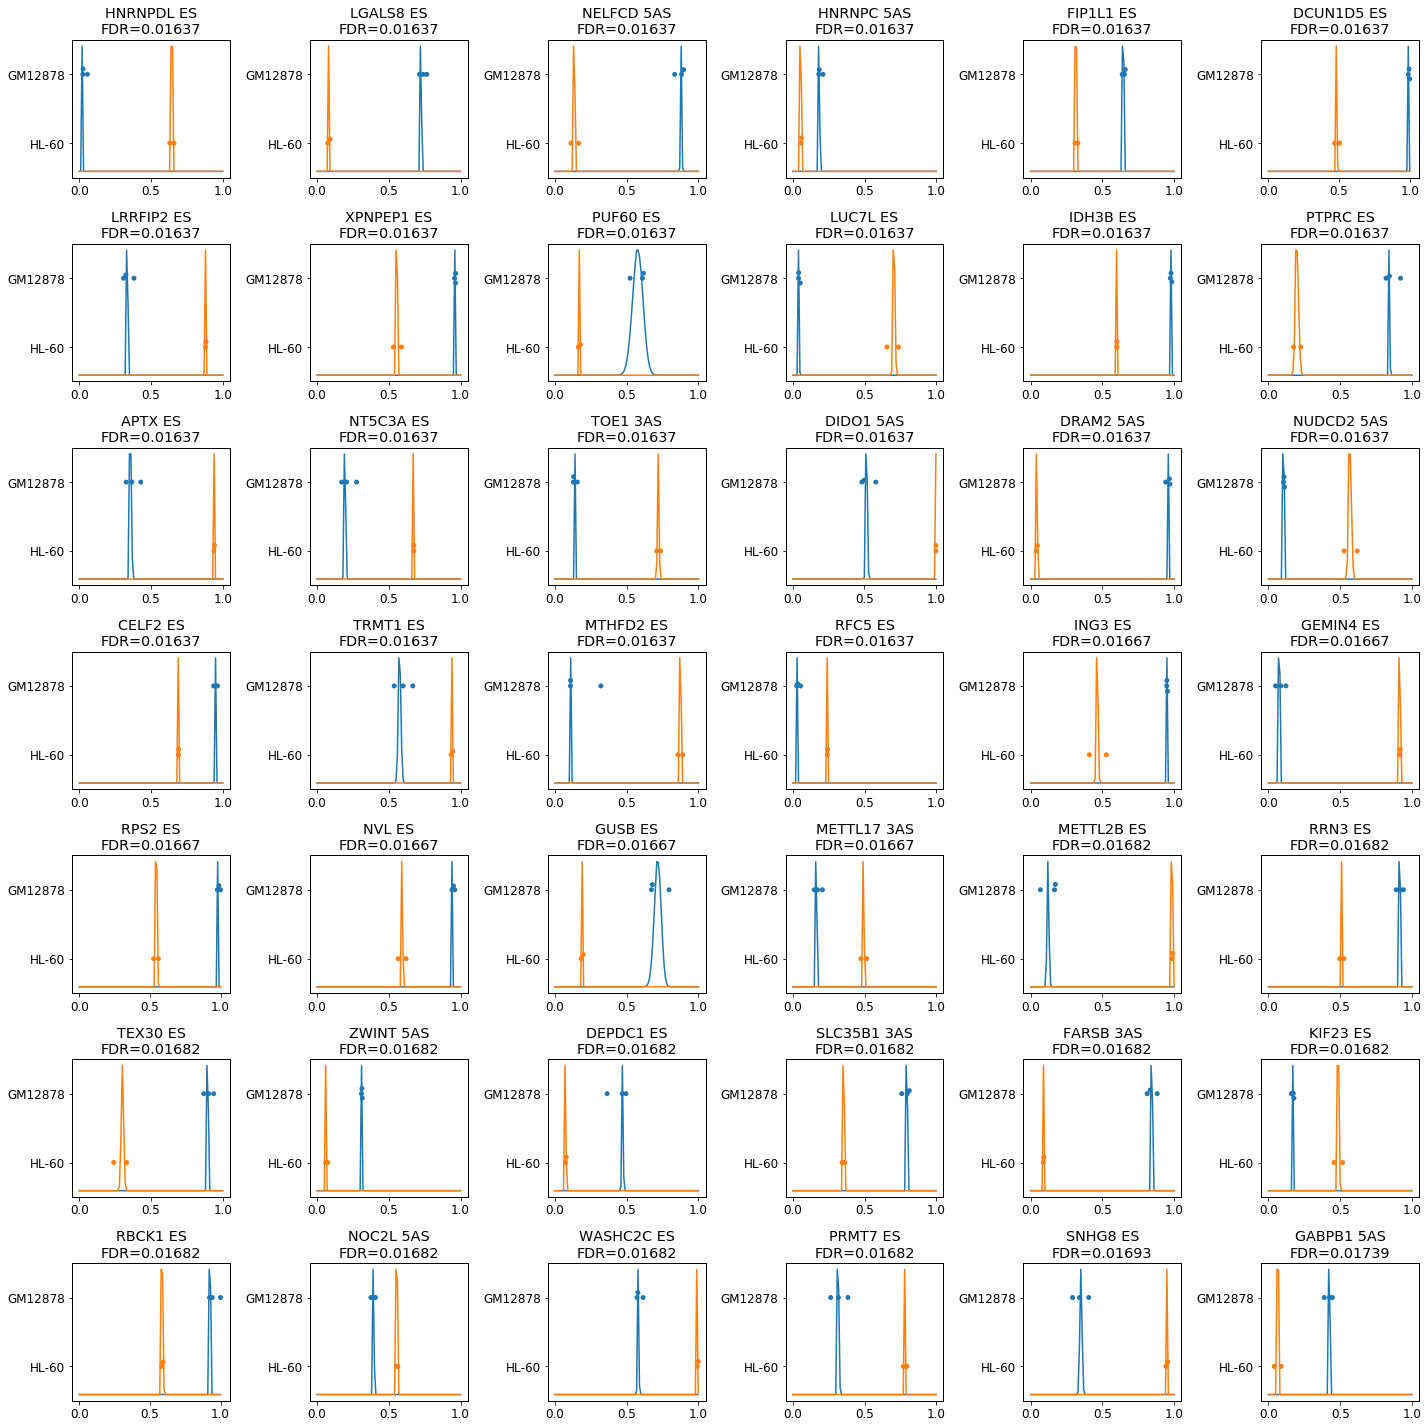

In [27]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

HNRNPDL ES (known) FDR=1.64e-02: GM12878=2.8 vs HL-60=65.0 PSI


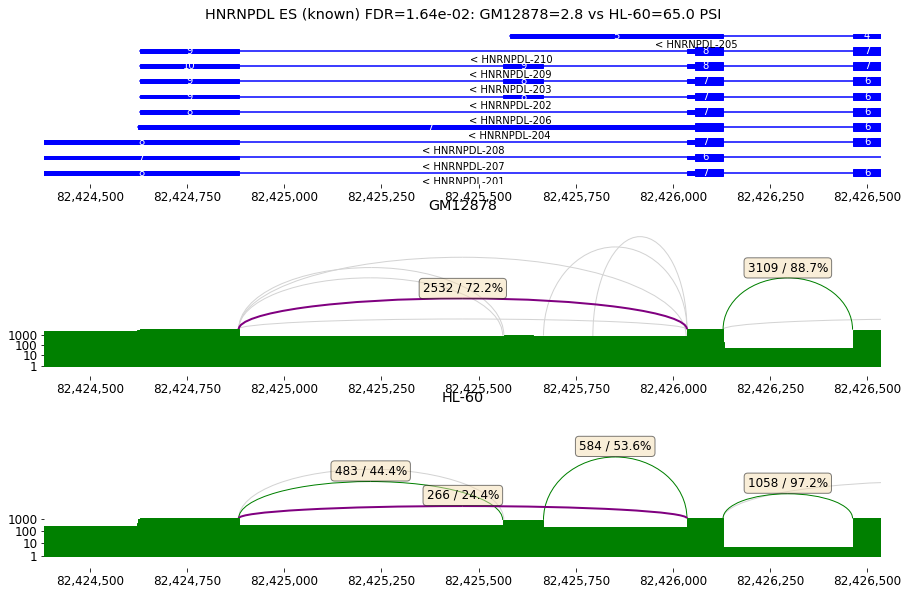

In [28]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,20)
#1) select gene of interest: 3rd row, exon skipping of HNRNPDL
row=res[diff_cmp].iloc[3]
plot_diff_example(row, isoseq, groups)

In [29]:
diff_cmp='GM12878/K562'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for GM12878 (3) vs K562 (3) using betabinom_lr test
100%|██████████| 529144/529144 [18:18<00:00, 481.87it/s] 


3937 differential splice sites in 2537 genes for GM12878 vs K562


index      gene             gene_id  chrom strand      start        end  \
0    4653      CD59  ENSG00000085063.17  chr11      -   33722463   33736381   
7    4135    MRPL21  ENSG00000197345.13  chr11      -   68898012   68900547   
10   6021  RAD51AP1  ENSG00000111247.15  chr12      +    4553147    4558856   
12  14589    POLR2D  ENSG00000144231.11   chr2      -  127850685  127858027   
15  22988     TNPO3  ENSG00000064419.13   chr7      -  129018157  129054650   
16  20448    NUDCD2  ENSG00000170584.11   chr5      -  163457610  163459861   
19  23504    INSIG1  ENSG00000186480.13   chr7      +  155297959  155298258   
32  22022      MPC1  ENSG00000060762.19   chr6      -  166366891  166382805   
37  16590   CSNK2A1  ENSG00000101266.19  chr20      -     508660     543671   
38  13457    RUVBL2  ENSG00000183207.14  chr19      +   48993923   48999318   

   splice_type  novel      padj  ...  GM12878_1_1_b_GM12878_in_cov  \
0           ES  False  0.008935  ...                           100   
7          5AS  False  0.012259  ...                             7   
10          ES  False  0.012259  ...                            43   
12          ES   True  0.012259  ...                           201   
15          ES  False  0.012259  ...                            47   
16         5AS   True  0.012259  ...                            17   
19         5AS  False  0.012573  ...                             5   
32         3AS   True  0.013571  ...                            98   
37          ES  False  0.013571  ...                            67   
38          ES  False  0.013571  ...                             7   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
0                               529                         121   
7                               156                          19   
10                               48                          45   
12                              233                         288   
15                              374                          34   
16                              151                          24   
19                               69                           1   
32                              102                         166   
37                              281                          72   
38                              409                           8   

    GM12878_2_1_GM12878_total_cov  K562_1_1_K562_in_cov  \
0                             727                    27   
7                             270                    16   
10                             49                     7   
12                            329                     6   
15                            294                    33   
16                            229                    12   
19                             42                    36   
32                            173                     3   
37                            373                    17   
38                            294                    41   

    K562_1_1_K562_total_cov  K562_1_1_b_K562_in_cov  \
0                        29                      55   
7                        24                      33   
10                       41                       5   
12                       41                      11   
15                       57                      41   
16                       16                      40   
19                       69                      56   
32                        8                       2   
37                       24                      21   
38                       66                      20   

    K562_1_1_b_K562_total_cov  K562_2_1_K562_in_cov  K562_2_1_K562_total_cov  
0                          57                    47                       49  
7                          50                    29                       44  
10                         34                     7                       39  
12                         93                     9  

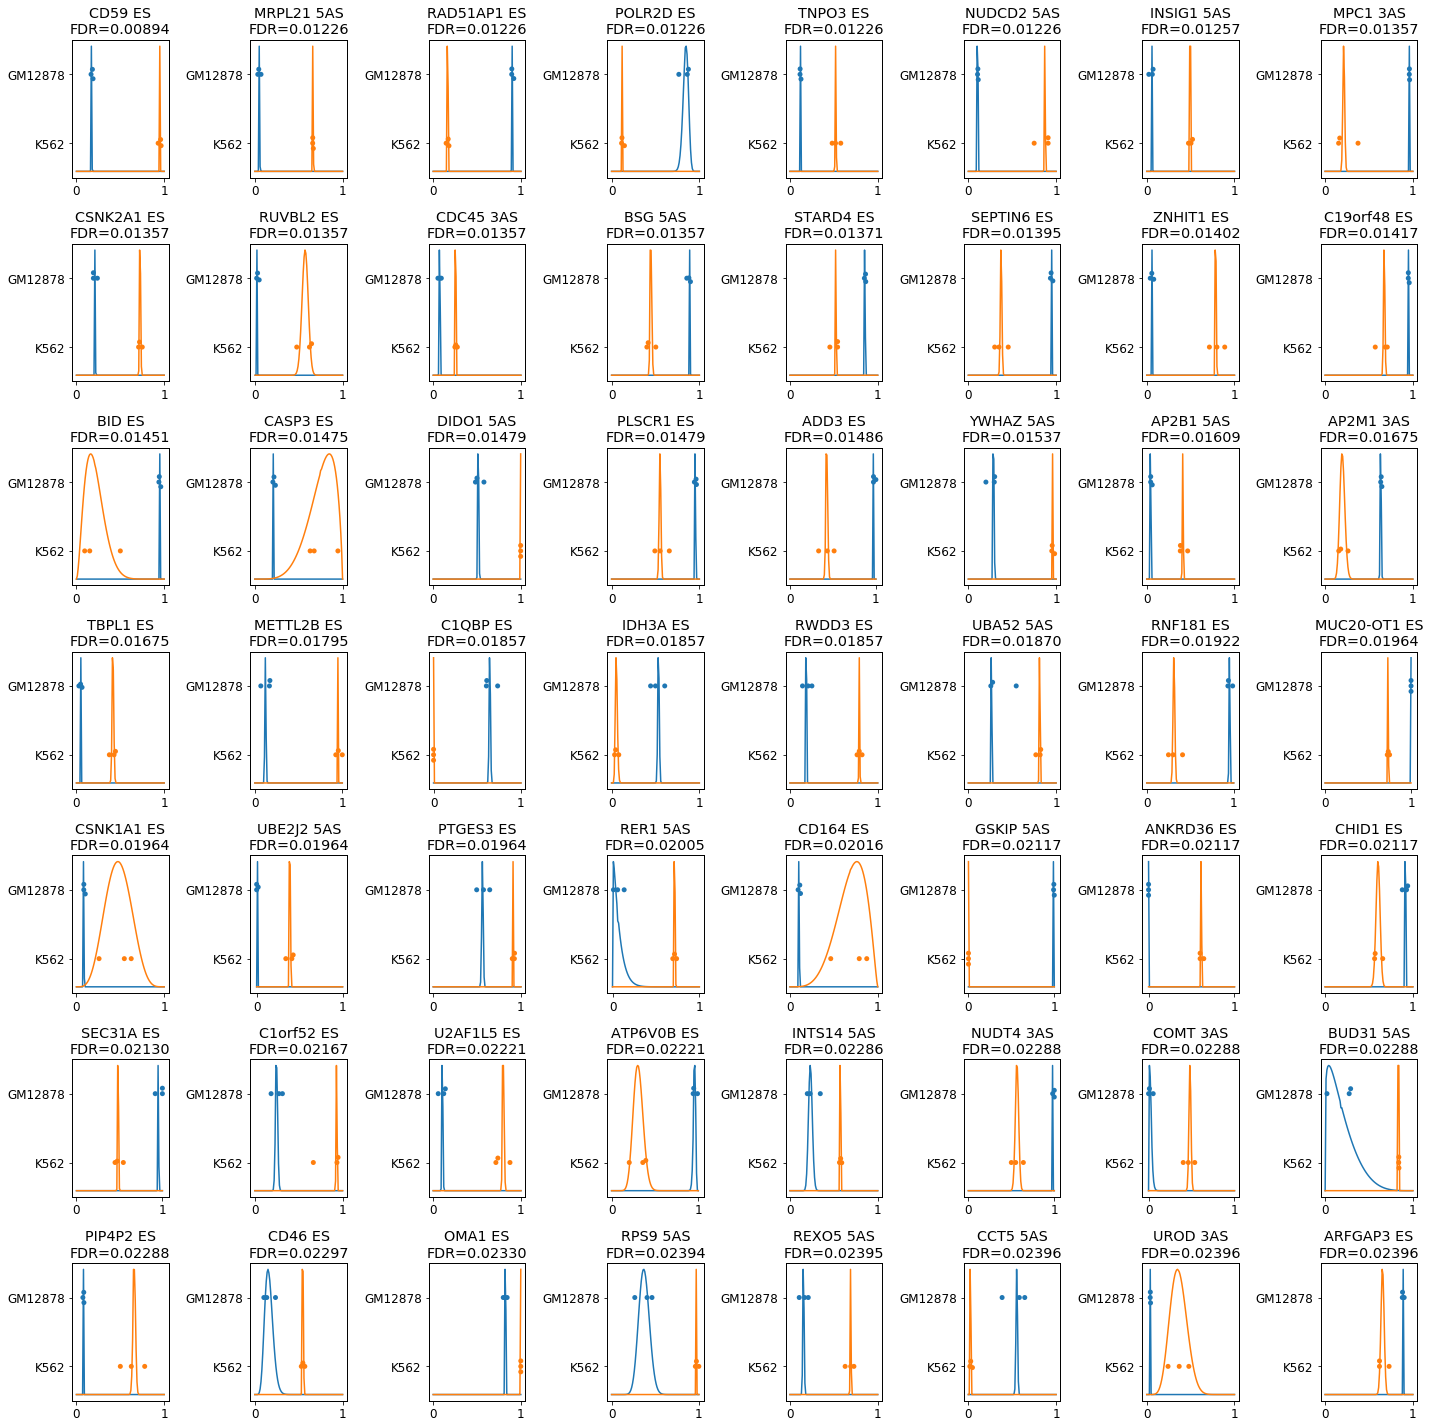

In [30]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,8),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

CD59 ES (known) FDR=8.94e-03: GM12878=17.7 vs K562=95.5 PSI


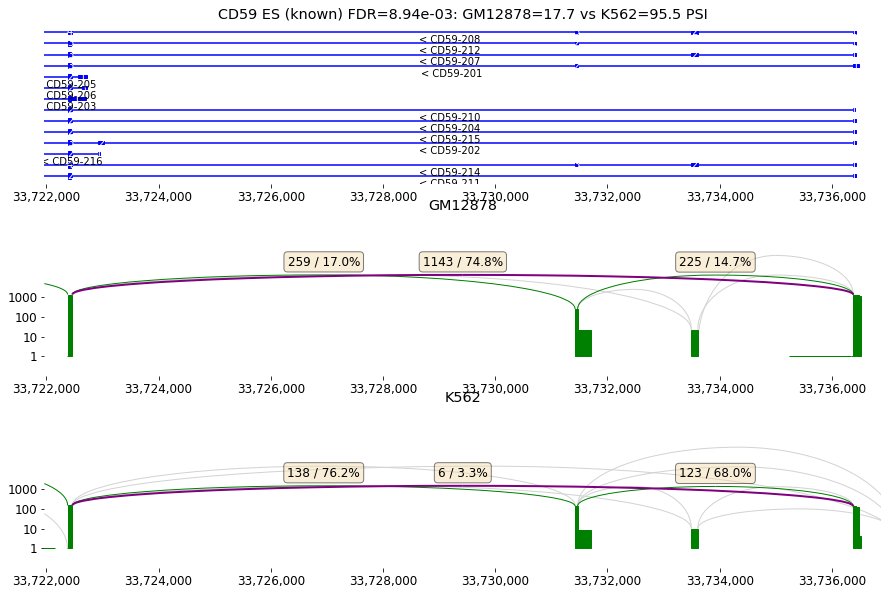

In [31]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[0]
plot_diff_example(row, isoseq, groups)

In [32]:
gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'GM12878':gr['GM12878']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs GM12878 (3) using betabinom_lr test
100%|██████████| 529144/529144 [17:47<00:00, 495.83it/s] 


1472 differential splice sites in 1105 genes for leukemia vs GM12878


index       gene             gene_id  chrom strand      start        end  \
5    1014      ACADM  ENSG00000117054.14   chr1      +   75724817   75732643   
10   9261     INTS14  ENSG00000138614.15  chr15      -   65607442   65611097   
11   9167      IDH3A  ENSG00000166411.14  chr15      +   78155275   78157547   
13  16725      DIDO1  ENSG00000101191.17  chr20      -   62914406   62926438   
19  24574    METTL2B  ENSG00000165055.16   chr7      +  128476875  128479157   
22   2144      PTPRC  ENSG00000081237.20   chr1      +  198692373  198703297   
39  21188     NUDCD2  ENSG00000170584.11   chr5      -  163457610  163459861   
41  15339    SLC20A1  ENSG00000144136.11   chr2      +  112652798  112657121   
42  19444  MUC20-OT1   ENSG00000242086.8   chr3      +  195658165  195662570   
52  24152     ZDHHC4  ENSG00000136247.15   chr7      +    6577498    6578565   

   splice_type  novel      padj  ...  HL-60_1_1_leukemia_in_cov  \
5           ES  False  0.009102  ...                        264   
10         5AS  False  0.010380  ...                        135   
11          ES  False  0.011200  ...                         16   
13         5AS   True  0.011200  ...                        174   
19          ES  False  0.011276  ...                        122   
22          ES  False  0.011846  ...                         67   
39         5AS   True  0.013270  ...                         67   
41          ES  False  0.013400  ...                         49   
42          ES   True  0.013439  ...                         77   
52          ES  False  0.015743  ...                         98   

    HL-60_1_1_leukemia_total_cov  HL-60_2_1_leukemia_in_cov  \
5                            325                        206   
10                           224                        111   
11                           433                         28   
13                           174                        156   
19                           123                         67   
22                           297                         58   
39                           127                         65   
41                           299                         42   
42                            91                         40   
52                           160                         65   

    HL-60_2_1_leukemia_total_cov  GM12878_1_1_GM12878_in_cov  \
5                            256                         155   
10                           181                          19   
11                           352                           8   
13                           156                          29   
19                            68                           3   
22                           331                          58   
39                           105                           9   
41                           226                           3   
42                            55                          27   
52                           102                           8   

    GM12878_1_1_GM12878_total_cov  GM12878_1_1_b_GM12878_in_cov  \
5                             164                         802.0   
10                             55                          37.0   
11                             18                          43.0   
13                             50                          38.0   
19                             18                           5.0   
22                             63                         186.0   
39                             83                          17.0   
41                            129                           7.0   
42                             27                          38.0   
52                             15                           0.0   

    GM12878_1_1_b_GM12878_total_cov  GM12878_2_1_GM12878_in_cov  \
5                             836.0                      1104.0   
10                            161.0                        44.0   
11                             71.0            

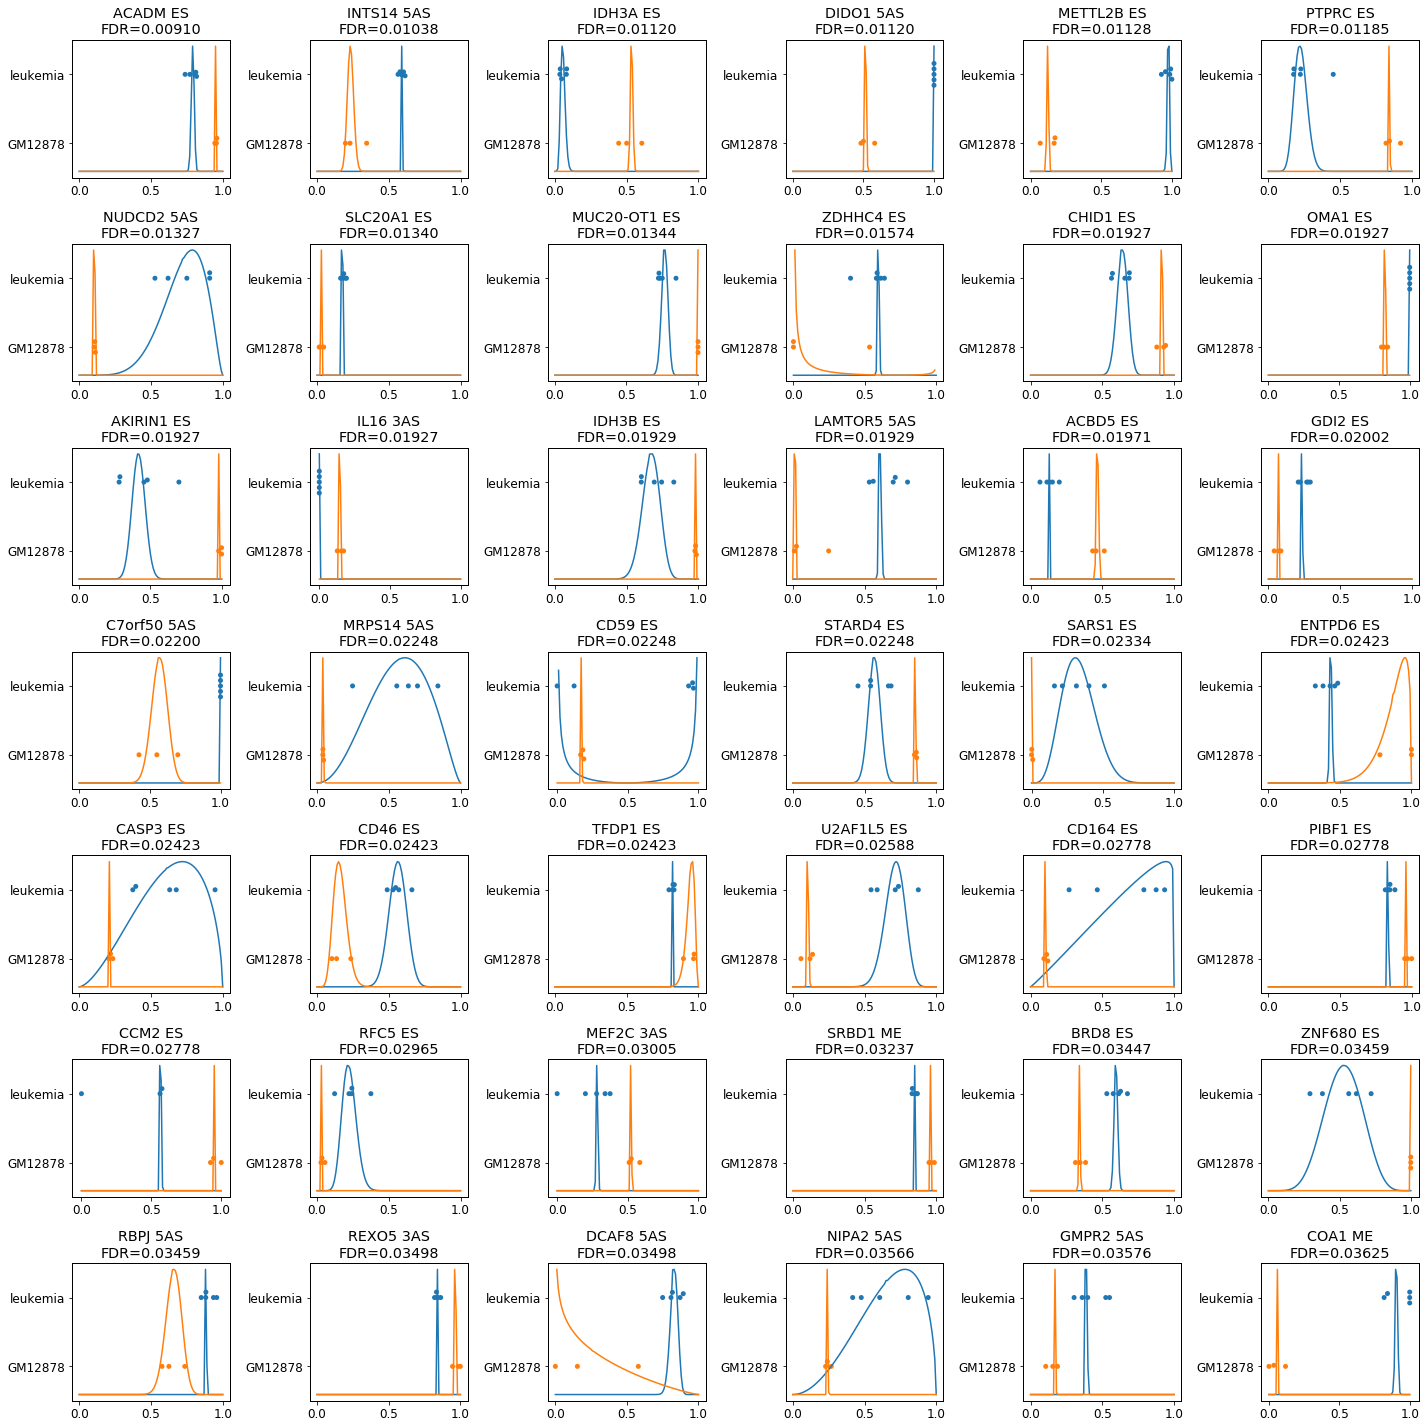

In [33]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=2, splice_types=types_of_interest)
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

METTL2B ES (known) FDR=1.13e-02: leukemia=97.6 vs GM12878=12.1 PSI


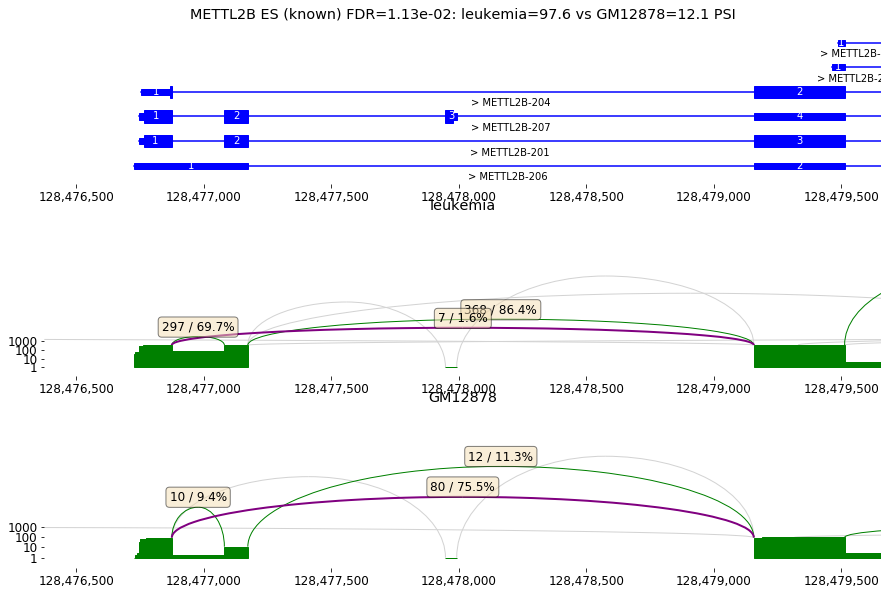

In [34]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[19]
plot_diff_example(row, isoseq, groups)

### Carcinoma Cell lines
Carcinomas often feature mutations in RBM10 or deregulation of SRSF1, SRSF3 and SRSF6, each leading to specific splicing defects. 

In [35]:

diff_cmp='Panc1/progenitor cell of endocrine pancreas'
groups={k:isoseq.groups()[k] for k in diff_cmp.split('/')}


#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for Panc1 (1) vs progenitor cell of endocrine pancreas (2) using proportions test
  1%|          | 6422/529144 [00:00<00:09, 53369.86it/s]/home/lienhard/.local/lib/python3.7/site-packages/isotools/_transcriptome_stats.py:23: RuntimeWarning: invalid value encountered in long_scalars
  p1=[x[i]/n[i] for i in range(2)]
/home/lienhard/.local/lib/python3.7/site-packages/isotools/_transcriptome_stats.py:25: RuntimeWarning: divide by zero encountered in long_scalars
  z=abs(p1[0]-p1[1])/np.sqrt(p0*(1-p0)*(1/n[0]+1/n[1]))
100%|██████████| 529144/529144 [07:03<00:00, 1249.45it/s]


7927 differential splice sites in 3556 genes for Panc1 vs progenitor cell of endocrine pancreas


index     gene             gene_id  chrom strand      start        end  \
61    3450    RPLP0  ENSG00000089157.16  chr12      -  120200831  120201082   
87    5997   SNHG16  ENSG00000163597.15  chr17      +   76557857   76561287   
109  12222    CD164  ENSG00000135535.17   chr6      -  109369017  109376073   
130   2913   NAP1L4  ENSG00000205531.13  chr11      -    2979237    2992253   
132   2637     CD59  ENSG00000085063.17  chr11      -   33722463   33736381   
139  12648     CALU  ENSG00000128595.17   chr7      +  128748804  128758870   
189   3392     KRT8  ENSG00000170421.12  chr12      -   52900062   52900587   
193  10375    EXOC1  ENSG00000090989.18   chr4      +   55883928   55890222   
195   3513  SLC25A3  ENSG00000075415.13  chr12      +   98593740   98593978   
209   2963   PPP1CA  ENSG00000172531.16  chr11      -   67400919   67401727   

    splice_type  novel           padj  ...  \
61          3AS  False  1.068223e-149  ...   
87           ES  False  2.596972e-112  ...   
109          ES  False   6.857292e-97  ...   
130         5AS  False   3.177983e-87  ...   
132          ES  False   2.179653e-86  ...   
139          ME  False   7.273237e-82  ...   
189         3AS   True   1.554934e-60  ...   
193          ES  False   6.301650e-60  ...   
195         3AS  False   2.298308e-59  ...   
209          ES  False   4.082866e-54  ...   

     progenitor cell of endocrine pancreas_PSI  \
61                                    0.059271   
87                                    0.086667   
109                                   0.892730   
130                                   0.085624   
132                                   0.179406   
139                                   0.822660   
189                                   0.978887   
193                                   0.959627   
195                                   0.256329   
209                                   0.958824   

     progenitor cell of endocrine pancreas_disp  total_PSI  total_disp  \
61                                            0   0.108604           0   
87                                            0   0.289373           0   
109                                           0   0.806075           0   
130                                           0   0.190141           0   
132                                           0   0.288462           0   
139                                           0   0.744892           0   
189                                           0   0.878487           0   
193                                           0   0.833333           0   
195                                           0   0.566494           0   
209                                           0   0.794989           0   

     Panc1_1_1_Panc1_in_cov  Panc1_1_1_Panc1_total_cov  \
61                      114                        153   
87                      174                        181   
109                      28                        156   
130                     135                        190   
132                     146                        150   
139                      34                        194   
189                     397                        571   
193                       1                         50   
195                     247                        263   
209                      23                         99   

     progenitor_cell_of_endocrine_pancreas_2_1_progenitor cell of endocrine pancreas_in_cov  \
61                                                  52                                        
87                                                  19                                        
109                                                995                                        
130                                                 24                                        
132                                                 77                                        
139                                               111

CALU ME (known) FDR=7.27e-82: Panc1=17.5 vs progenitor cell of endocrine pancreas=82.3 PSI


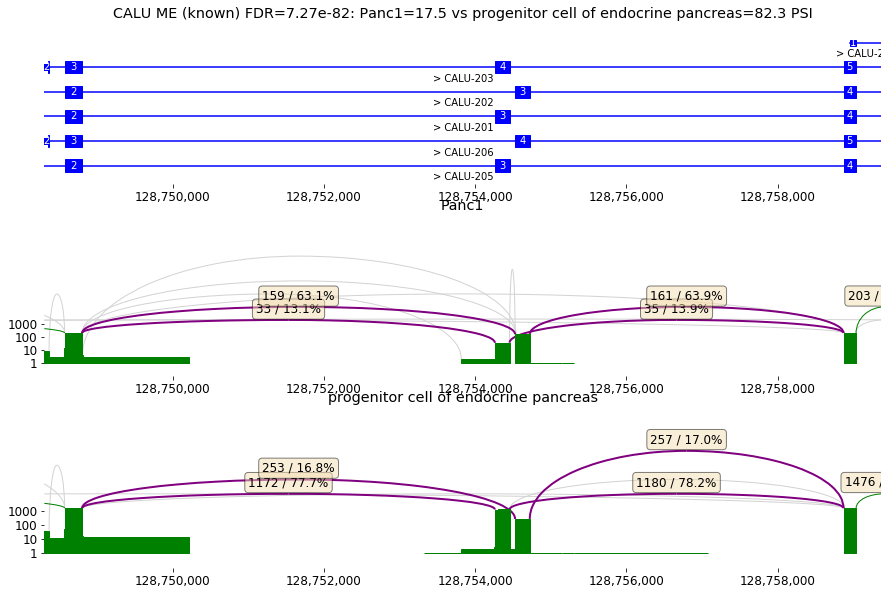

In [36]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[139]
plot_diff_example(row, isoseq, groups)

In [37]:
#all carcinoma vs normal endoderm
karyotype=isoseq.groups('karyotype')
lineage=isoseq.groups('lineage')
cell=isoseq.groups('cell')

groups={'carcinoma':[sa for sa in karyotype['cancer'] if sa in cell['epithelial cell']], 
        'normal endoderm':[sa for sa in karyotype['normal'] if sa in lineage['endoderm']]}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for carcinoma (5) vs normal endoderm (8) using betabinom_lr test
100%|██████████| 529144/529144 [20:35<00:00, 428.30it/s]  


8960 differential splice sites in 4935 genes for carcinoma vs normal endoderm


index    gene             gene_id  chrom strand      start        end  \
4   24621    NHP2   ENSG00000145912.9   chr5      -  178149838  178153490   
13   1212   RPL11  ENSG00000142676.14   chr1      +   23691829   23692611   
37  21399  CHMP2B  ENSG00000083937.10   chr3      +   87227556   87240698   
43   4375   BANF1   ENSG00000175334.8  chr11      +   66002513   66003234   
58  14461   NARS1  ENSG00000134440.12  chr18      -   57620648   57621707   
62  28793   THEM6   ENSG00000130193.8   chr8      +  142727700  142735325   
65  24796    BTF3  ENSG00000145741.16   chr5      +   73498558   73499133   
66  26338    SNX3  ENSG00000112335.15   chr6      -  108223045  108260825   
71  19764   MRPS6   ENSG00000243927.6  chr21      +   34073745   34125340   
91  15104  PWWP3A  ENSG00000160953.16  chr19      +    1358464    1360135   

   splice_type  novel      padj  ...  \
4           ES  False  0.000022  ...   
13         3AS  False  0.000091  ...   
37          ES  False  0.000131  ...   
43         5AS  False  0.000166  ...   
58         3AS  False  0.000209  ...   
62         5AS   True  0.000216  ...   
65         5AS  False  0.000221  ...   
66         5AS  False  0.000221  ...   
71          ES  False  0.000240  ...   
91          ES  False  0.000312  ...   

    endodermal_cell_1_1_normal endoderm_in_cov  \
4                                          117   
13                                         830   
37                                           5   
43                                          59   
58                                         951   
62                                          51   
65                                          95   
66                                          62   
71                                          50   
91                                          10   

    endodermal_cell_1_1_normal endoderm_total_cov  \
4                                             120   
13                                            954   
37                                             99   
43                                             77   
58                                           1256   
62                                             53   
65                                            772   
66                                             63   
71                                            454   
91                                             68   

    endodermal_cell_2_1_normal endoderm_in_cov  \
4                                           65   
13                                         520   
37                                           7   
43                                          36   
58                                          63   
62                                          48   
65                                          65   
66                                          37   
71                                          44   
91                                          15   

    endodermal_cell_2_1_normal endoderm_total_cov  \
4                                              65   
13                                            587   
37                                            110   
43                                             45   
58                                            340   
62                                             51   
65                                            502   
66                                             38   
71                                            367   
91                                            125   

    type_B_pancreatic_cell_2_1_normal endoderm_in_cov  \
4                                                  49   
13                                                933   
37                                                  3   
43                                                 40   
58                                                 47   
62                                                 16   
65                                            

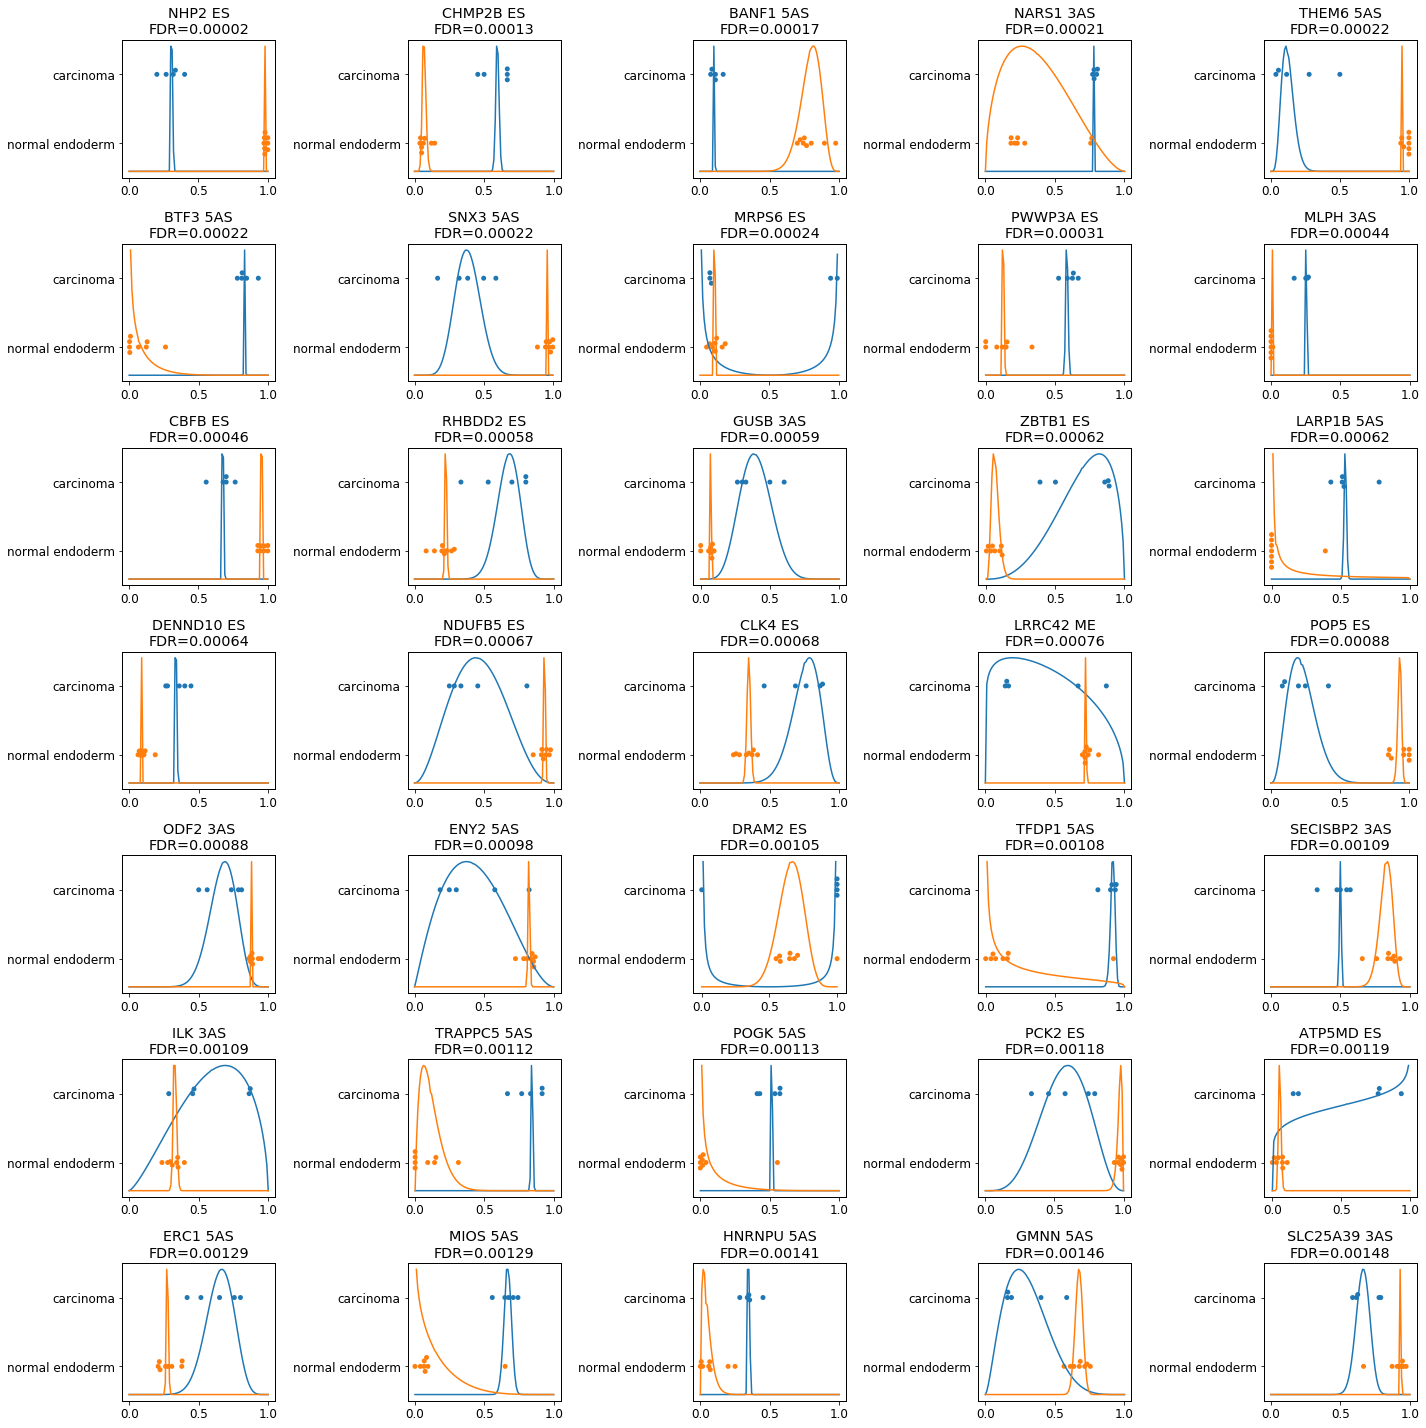

In [38]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,5),min_support=2, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

NHP2 ES (known) FDR=2.20e-05: carcinoma=30.9 vs normal endoderm=98.2 PSI


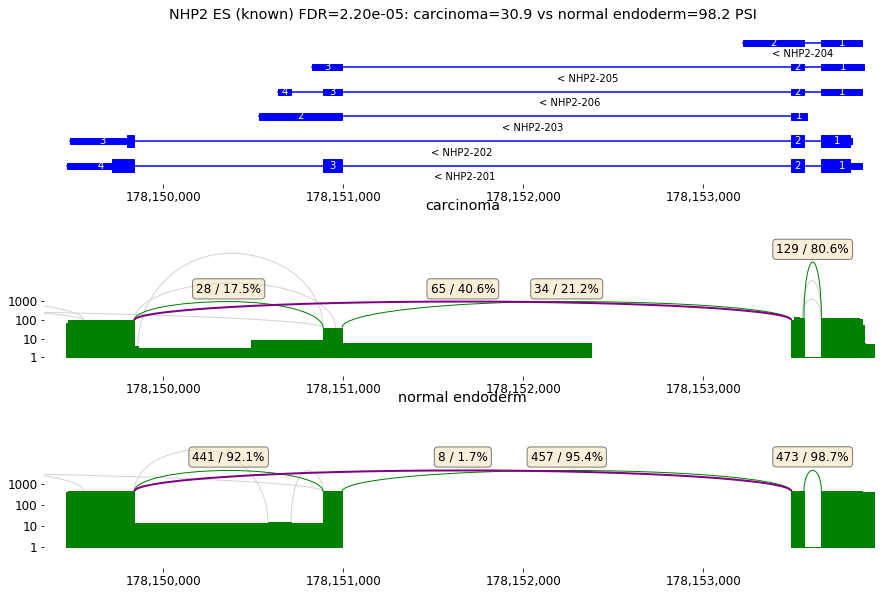

In [39]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[4]
plot_diff_example(row, isoseq, groups)

In [40]:
#differential splicing all leukemia vs carcinoma

gr=isoseq.groups()
groups={'leukemia':gr['K562']+gr['HL-60'], 'carcinoma':gr['Panc1']+gr['HCT116']+gr['HepG2']+gr['PC-3']+gr['MCF-7']}
diff_cmp='/'.join(groups)

#takes about 30 min
res[diff_cmp]=isoseq.altsplice_test(groups).sort_values('pvalue').reset_index()
res[diff_cmp].to_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv', index=False)
#res[diff_cmp]=pd.read_csv(f'encode_diff_betabinomial_{"_".join(groups)}.csv')
sig=res[diff_cmp].padj<.1
print(f'{sum(sig)} differential splice sites in {len(res[diff_cmp].loc[sig,"gene"].unique())} genes for {" vs ".join(groups)}')
res[diff_cmp][res[diff_cmp].splice_type.isin(types_of_interest)].head(10)

INFO:testing differential splicing for leukemia (5) vs carcinoma (5) using betabinom_lr test
100%|██████████| 529144/529144 [21:43<00:00, 405.88it/s] 


2199 differential splice sites in 1597 genes for leukemia vs carcinoma


index     gene             gene_id  chrom strand      start        end  \
0    6424   NAP1L4  ENSG00000205531.13  chr11      -    2945646    2951258   
1   32990  HNRNPH2   ENSG00000126945.9   chrX      +  101408307  101411935   
7   26868     BTF3  ENSG00000145741.16   chr5      +   73498558   73499133   
18  28454    HMGA1  ENSG00000137309.20   chr6      +   34240882   34242711   
19  19993     AAMP  ENSG00000127837.10   chr2      -  218269534  218269965   
23  27197    PNISR  ENSG00000132424.16   chr6      -   99402710   99404602   
24   9616     INF2  ENSG00000203485.14  chr14      +  104714856  104718794   
36  30932    SDCBP  ENSG00000137575.12   chr8      +   58572314   58575902   
39  15855    NARS1  ENSG00000134440.12  chr18      -   57620648   57621707   
50  23532   CHMP2B  ENSG00000083937.10   chr3      +   87227556   87240698   

   splice_type  novel      padj  ...  Panc1_1_1_carcinoma_in_cov  \
0           ES  False  0.003183  ...                          54   
1          5AS   True  0.003614  ...                         368   
7          5AS  False  0.007075  ...                          39   
18         5AS  False  0.012529  ...                          41   
19         3AS  False  0.012529  ...                          33   
23         5AS  False  0.013481  ...                           8   
24          ES  False  0.013803  ...                          73   
36         3AS  False  0.014758  ...                          17   
39         3AS  False  0.014758  ...                         224   
50          ES  False  0.015757  ...                           6   

    Panc1_1_1_carcinoma_total_cov  HCT116_1_1_carcinoma_in_cov  \
0                             265                           85   
1                             406                            1   
7                              42                           51   
18                            113                          266   
19                             49                           36   
23                             15                            3   
24                             78                           29   
36                             97                           16   
39                            278                          313   
50                              9                            8   

    HCT116_1_1_carcinoma_total_cov  HepG2_1_1_carcinoma_in_cov  \
0                              394                          81   
1                               22                           1   
7                               63                          56   
18                             597                          43   
19                              61                          11   
23                               4                           4   
24                              32                          73   
36                              81                         113   
39                             406                         570   
50                              12                           3   

    HepG2_1_1_carcinoma_total_cov  PC-3_1_1_carcinoma_in_cov  \
0                             459                         44   
1                              39                          1   
7                              72                         13   
18                             95                         97   
19                             88                         37   
23                              5                          3   
24                             91                         28   
36                            146                         65   
39                            730                        412   
50                              6                          5   

    PC-3_1_1_carcinoma_total_cov  MCF-7_1_1_carcinoma_in_cov  \
0                            298                          47   
1                             45                           1   
7                             16             

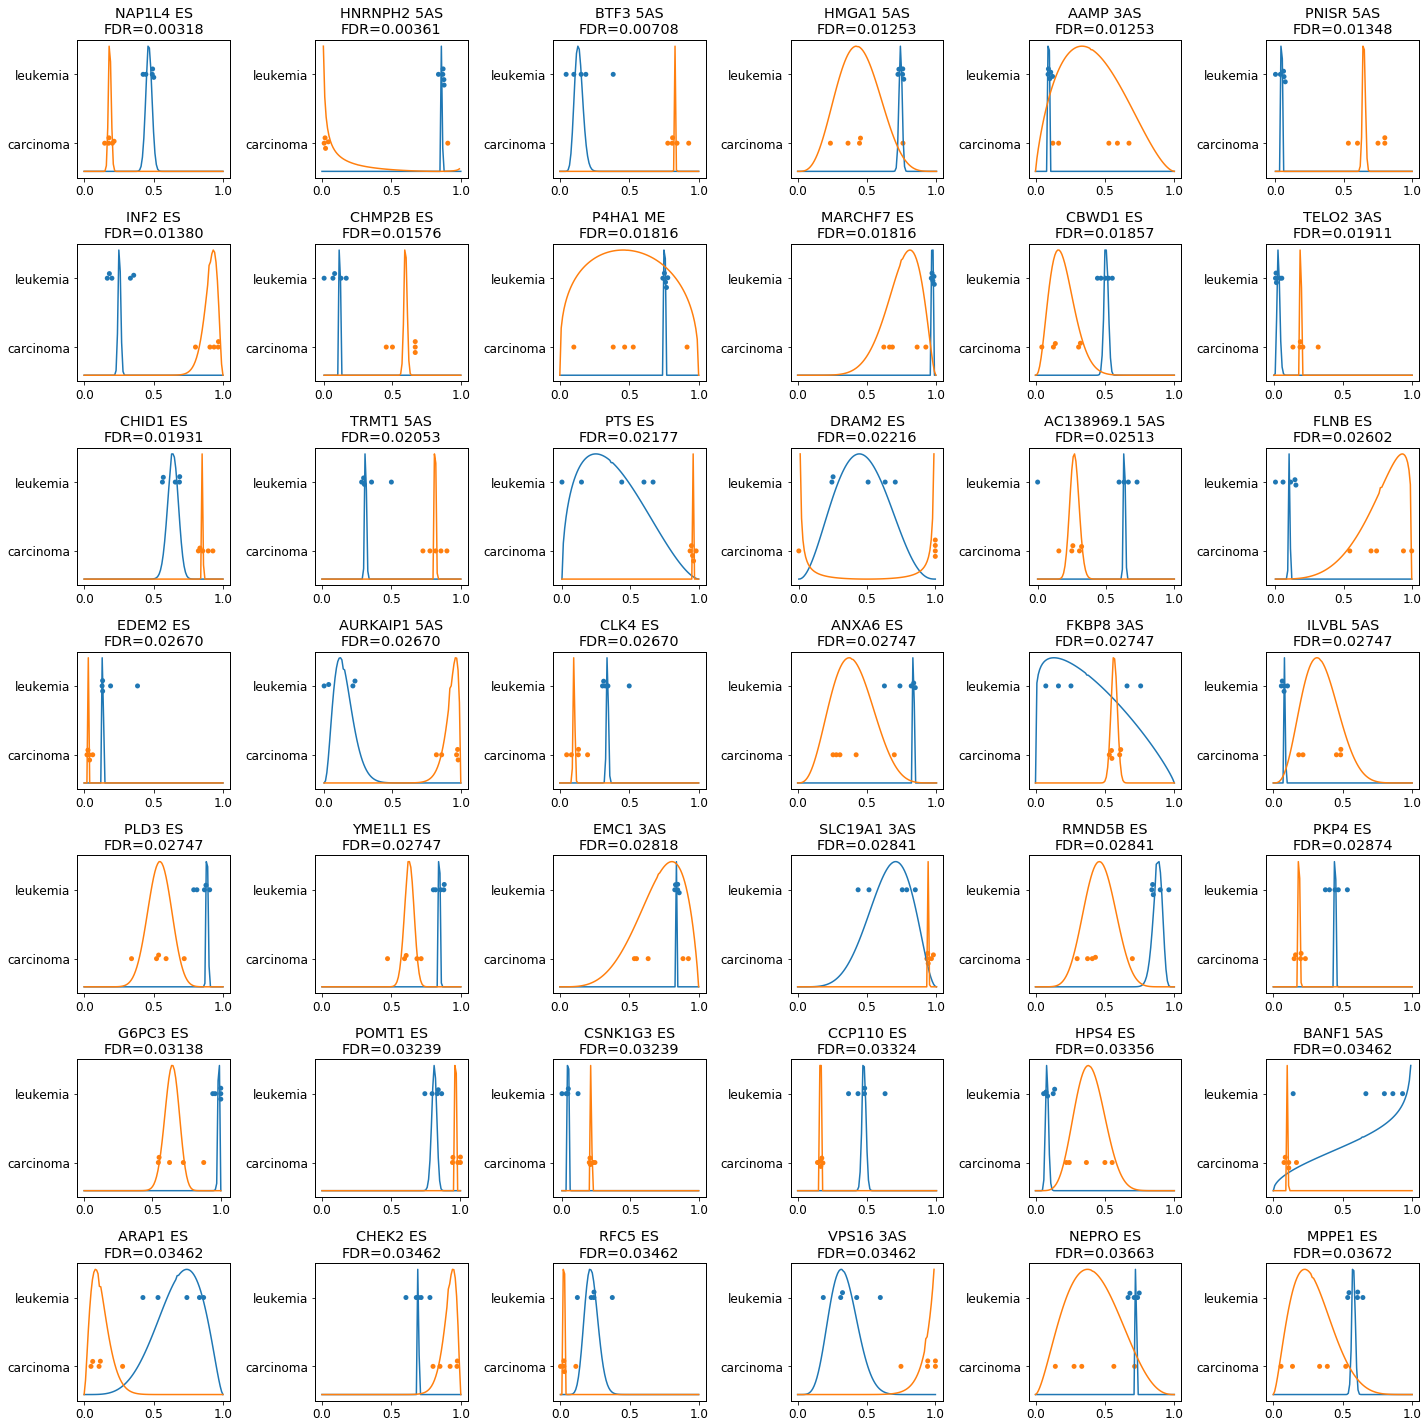

In [41]:

plt.rcParams["figure.figsize"] = (20,20)
f,axs,plotted=plot_diff_results(res[diff_cmp], min_diff=.1,grid_shape=(7,6),min_support=3, splice_types=['ES', 'ME', '5AS', '3AS'])
f.savefig(f'encode_diff_betabinomial_{"_".join(groups)}.png')
plotted.to_csv(f'encode_diff_betabinomial_plot_{"_".join(groups)}.csv', index=False)

NAP1L4 ES (known) FDR=3.18e-03: leukemia=46.6 vs carcinoma=18.5 PSI


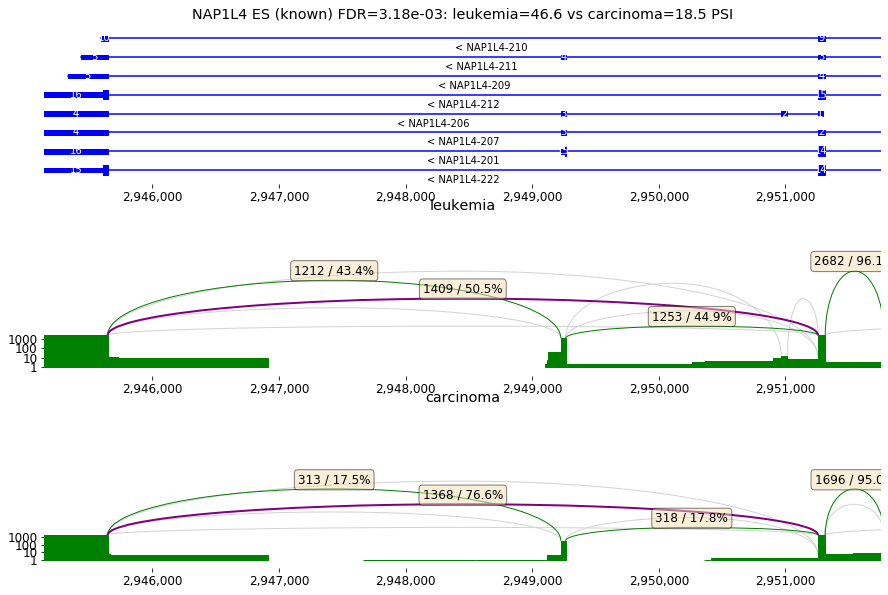

In [42]:
#sashimi plot for differential spliced genes
plt.rcParams["figure.figsize"] = (15,10)
#1) select gene of interest
row=res[diff_cmp].iloc[0]
plot_diff_example(row, isoseq, groups)